<a href="https://colab.research.google.com/github/guifav/machine_learning_tutoriais/blob/main/3_1_classificacao_completa_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Tutorial Completo: Classificação em Machine Learning

**Do básico ao avançado com Perceptron, Regressão Logística e XGBoost**

---

## Índice

1. [Introdução e Configuração](#1-introdução-e-configuração)
2. [O Dataset Iris](#2-o-dataset-iris)
3. [Análise Exploratória (EDA)](#3-análise-exploratória-eda)
4. [Preparação dos Dados](#4-preparação-dos-dados)
   - 4.1 Divisão Treino/Teste
   - 4.2 Padronização e Normalização
   - 4.3 Feature Engineering
5. [Fundamentos: Overfitting vs Underfitting](#5-fundamentos-overfitting-vs-underfitting)
6. [Modelo 1: Perceptron](#6-modelo-1-perceptron)
7. [Modelo 2: Regressão Logística](#7-modelo-2-regressão-logística)
   - 7.1 Regularização L1 e L2
8. [Modelo 3: XGBoost](#8-modelo-3-xgboost)
9. [Validação Cruzada (Cross-Validation)](#9-validação-cruzada)
10. [Tuning de Hiperparâmetros](#10-tuning-de-hiperparâmetros)
11. [Métricas Avançadas: ROC, AUC e Curvas PR](#11-métricas-avançadas)
12. [Lidando com Classes Desbalanceadas](#12-classes-desbalanceadas)
13. [Pipelines do Scikit-learn](#13-pipelines)
14. [Comparativo Final e Seleção de Modelo](#14-comparativo-final)
15. [Salvando e Carregando Modelos](#15-persistência-de-modelos)
16. [Conclusões e Próximos Passos](#16-conclusões)

---

**Pré-requisitos:** Python básico, noções de estatística

**Tempo estimado:** 2-3 horas para completar todo o material

---
## 1. Introdução e Configuração <a id='1-introdução-e-configuração'></a>

### O que é Classificação?

Classificação é uma tarefa de **aprendizado supervisionado** onde o objetivo é prever a **categoria** (classe) de uma observação com base em suas características (features).

**Exemplos práticos:**
- Detectar spam em emails (spam / não-spam)
- Diagnosticar doenças (positivo / negativo)
- Reconhecer dígitos escritos à mão (0-9)
- Classificar espécies de flores (nosso exemplo!)

### Tipos de Classificação

| Tipo | Classes | Exemplo |
|------|---------|--------|
| **Binária** | 2 | Spam ou não-spam |
| **Multiclasse** | 3+ (mutuamente exclusivas) | Espécies de flores |
| **Multilabel** | Múltiplas por amostra | Tags de um artigo |

In [1]:
# Instalação de dependências (já disponíveis no Colab)
!pip install xgboost imbalanced-learn -q

In [2]:
# ============================================
# IMPORTS - Organizados por categoria
# ============================================

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Dados
from sklearn.datasets import load_iris, make_classification

# Scikit-learn: Pré-processamento
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    validation_curve
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    LabelBinarizer
)

# Scikit-learn: Modelos
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.dummy import DummyClassifier

# Scikit-learn: Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Scikit-learn: Pipeline e utilidades
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn (para classes desbalanceadas)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Persistência de modelos
import joblib
import pickle

# Configurações
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Todas as bibliotecas carregadas com sucesso!")
print(f"📌 Random state definido: {RANDOM_STATE}")

✅ Todas as bibliotecas carregadas com sucesso!
📌 Random state definido: 42


---
## 2. O Dataset Iris <a id='2-o-dataset-iris'></a>

### História e Contexto

O dataset Iris foi introduzido pelo estatístico britânico **Ronald Fisher** em 1936 no artigo *"The use of multiple measurements in taxonomic problems"*. É considerado o "Hello World" do Machine Learning.

### Características do Dataset

| Atributo | Valor |
|----------|-------|
| Amostras | 150 |
| Features | 4 (todas numéricas) |
| Classes | 3 (balanceadas: 50 cada) |
| Valores faltantes | Nenhum |

### As 3 Espécies

1. **Iris Setosa** — facilmente separável das outras
2. **Iris Versicolor** — alguma sobreposição com Virginica
3. **Iris Virginica** — alguma sobreposição com Versicolor

In [3]:
# Carregar o dataset
iris = load_iris()

# Criar DataFrame estruturado
df = pd.DataFrame(
    data=iris.data,
    columns=iris.feature_names
)
df['target'] = iris.target
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# Renomear colunas para facilitar
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target', 'species']

print("📊 Informações do Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Classes: {list(iris.target_names)}")
print(f"   Features: {iris.feature_names}")
print("\n📋 Primeiras linhas:")
df.head(10)

📊 Informações do Dataset:
   Shape: (150, 6)
   Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
   Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

📋 Primeiras linhas:


,sepal_length,sepal_width,petal_length,petal_width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
5,5.4,3.9,1.7,0.4,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
7,5.0,3.4,1.5,0.2,0,setosa
8,4.4,2.9,1.4,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa


In [4]:
# Verificar tipos e valores nulos
print("🔍 Tipos de dados e valores nulos:")
print(df.info())
print(f"\n❓ Total de valores nulos: {df.isnull().sum().sum()}")

🔍 Tipos de dados e valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   target        150 non-null    int64   
 5   species       150 non-null    category
dtypes: category(1), float64(4), int64(1)
memory usage: 6.3 KB
None

❓ Total de valores nulos: 0


---
## 3. Análise Exploratória (EDA) <a id='3-análise-exploratória-eda'></a>

A Análise Exploratória de Dados (EDA) é **fundamental** antes de modelar. Objetivos:

1. Entender a distribuição das variáveis
2. Identificar outliers
3. Verificar correlações
4. Avaliar separabilidade das classes

In [5]:
# Estatísticas descritivas
print("📈 Estatísticas Descritivas:")
df.describe().round(2)

📈 Estatísticas Descritivas:


,sepal_length,sepal_width,petal_length,petal_width,target
count,150.00,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20,1.00
std,0.83,0.44,1.77,0.76,0.82
min,4.30,2.00,1.00,0.10,0.00
25%,5.10,2.80,1.60,0.30,0.00
50%,5.80,3.00,4.35,1.30,1.00
75%,6.40,3.30,5.10,1.80,2.00
max,7.90,4.40,6.90,2.50,2.00


In [6]:
# Estatísticas por classe
print("📊 Estatísticas por Espécie:")
df.groupby('species').agg(['mean', 'std']).round(2)

📊 Estatísticas por Espécie:


sepal_length       sepal_width       petal_length        \
                   mean   std        mean   std         mean   std   
species                                                              
setosa             5.01  0.35        3.43  0.38         1.46  0.17   
versicolor         5.94  0.52        2.77  0.31         4.26  0.47   
virginica          6.59  0.64        2.97  0.32         5.55  0.55   

           petal_width       target       
                  mean   std   mean  std  
species                                   
setosa            0.25  0.11    0.0  0.0  
versicolor        1.33  0.20    1.0  0.0  
virginica         2.03  0.27    2.0  0.0

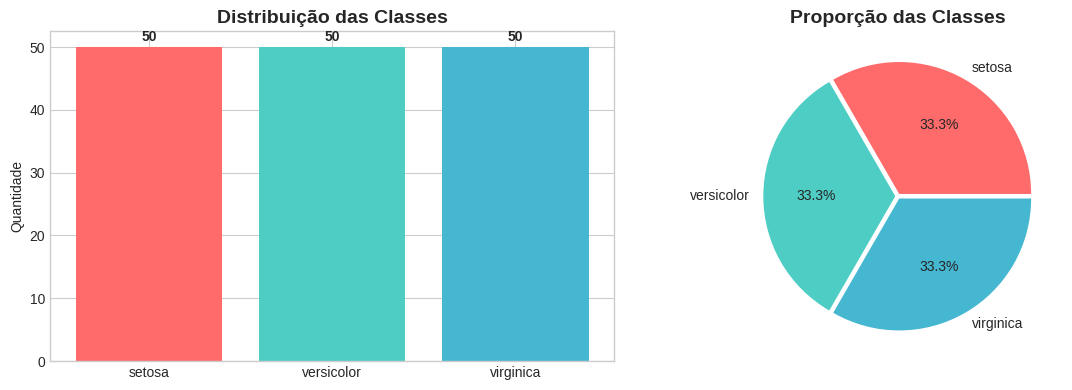

✅ Dataset BALANCEADO: cada classe tem exatamente 50 amostras (33.3%)


In [7]:
# Distribuição das classes (verificar balanceamento)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Contagem
class_counts = df['species'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Quantidade')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Proporção
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*3)
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Dataset BALANCEADO: cada classe tem exatamente 50 amostras (33.3%)")

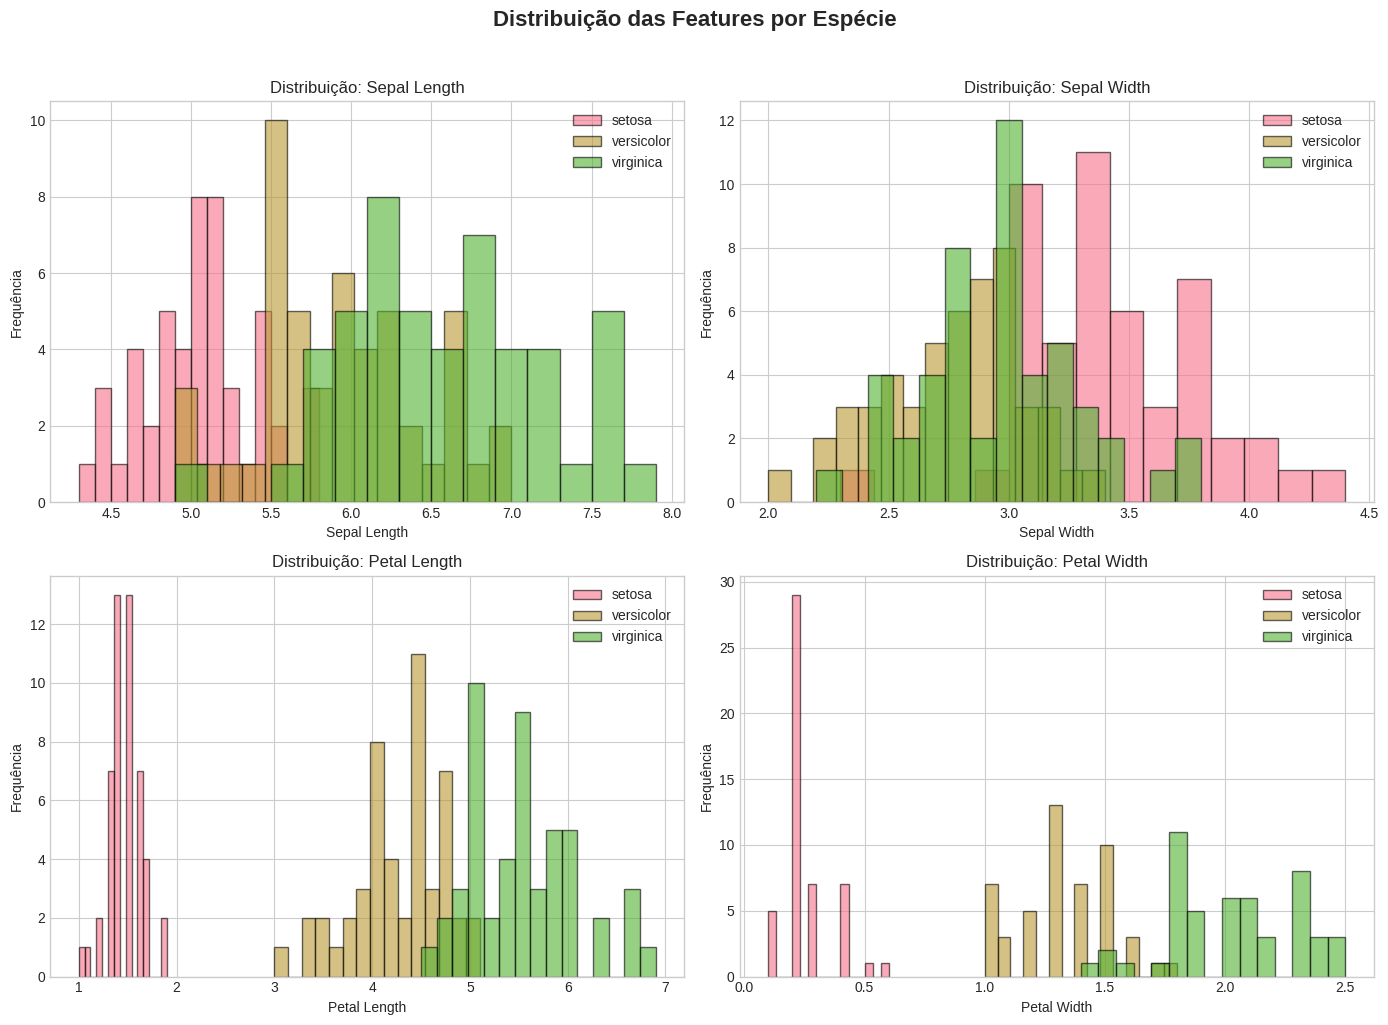

In [8]:
# Distribuição das features por classe (histogramas)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

for ax, feature in zip(axes.flat, features):
    for species in iris.target_names:
        subset = df[df['species'] == species][feature]
        ax.hist(subset, alpha=0.6, label=species, bins=15, edgecolor='black')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequência')
    ax.set_title(f'Distribuição: {feature.replace("_", " ").title()}', fontsize=12)
    ax.legend()

plt.suptitle('Distribuição das Features por Espécie', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

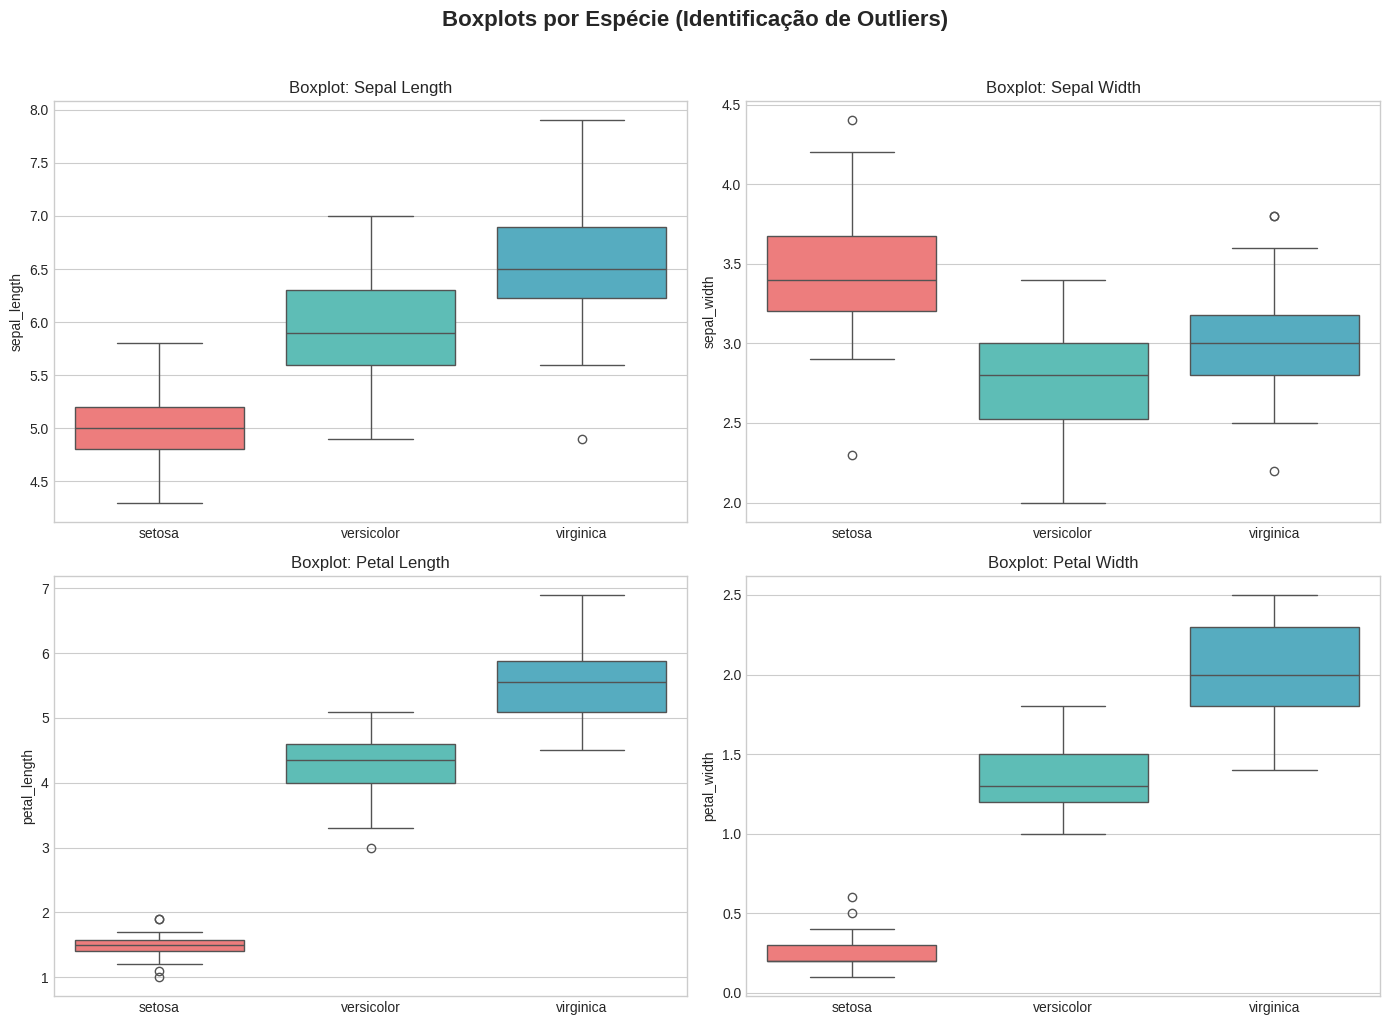

In [9]:
# Boxplots para identificar outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, feature in zip(axes.flat, features):
    sns.boxplot(data=df, x='species', y=feature, ax=ax, palette=colors)
    ax.set_title(f'Boxplot: {feature.replace("_", " ").title()}', fontsize=12)
    ax.set_xlabel('')

plt.suptitle('Boxplots por Espécie (Identificação de Outliers)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

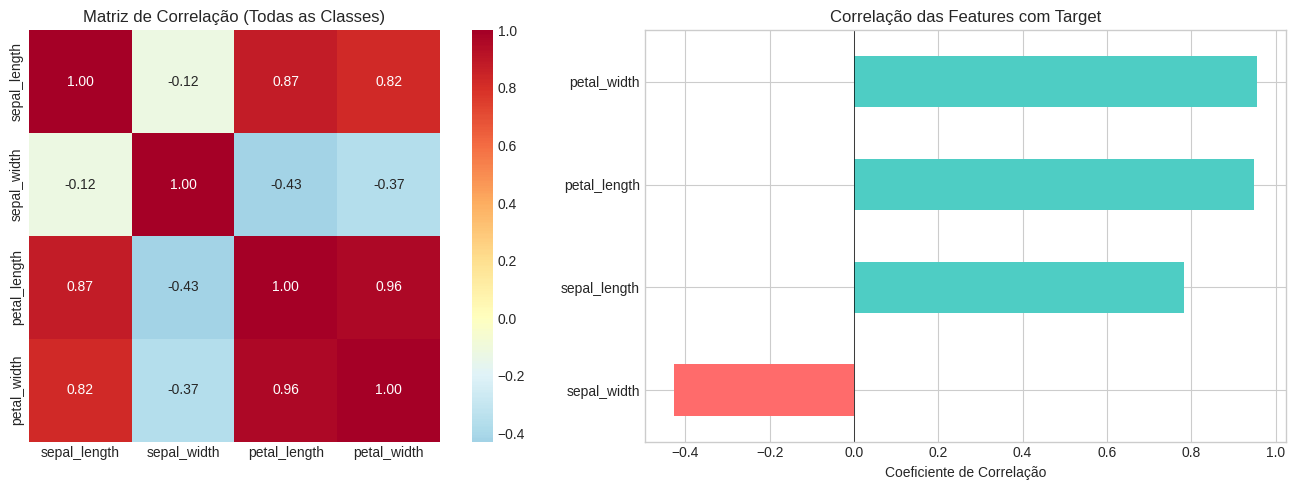

💡 Insight: petal_length e petal_width têm alta correlação com o target (boas preditoras)


In [10]:
# Matriz de correlação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlação geral
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, ax=axes[0], fmt='.2f')
axes[0].set_title('Matriz de Correlação (Todas as Classes)', fontsize=12)

# Correlação com target
corr_with_target = df[features + ['target']].corr()['target'][:-1].sort_values()
colors_bar = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in corr_with_target]
corr_with_target.plot(kind='barh', ax=axes[1], color=colors_bar)
axes[1].set_title('Correlação das Features com Target', fontsize=12)
axes[1].set_xlabel('Coeficiente de Correlação')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("💡 Insight: petal_length e petal_width têm alta correlação com o target (boas preditoras)")

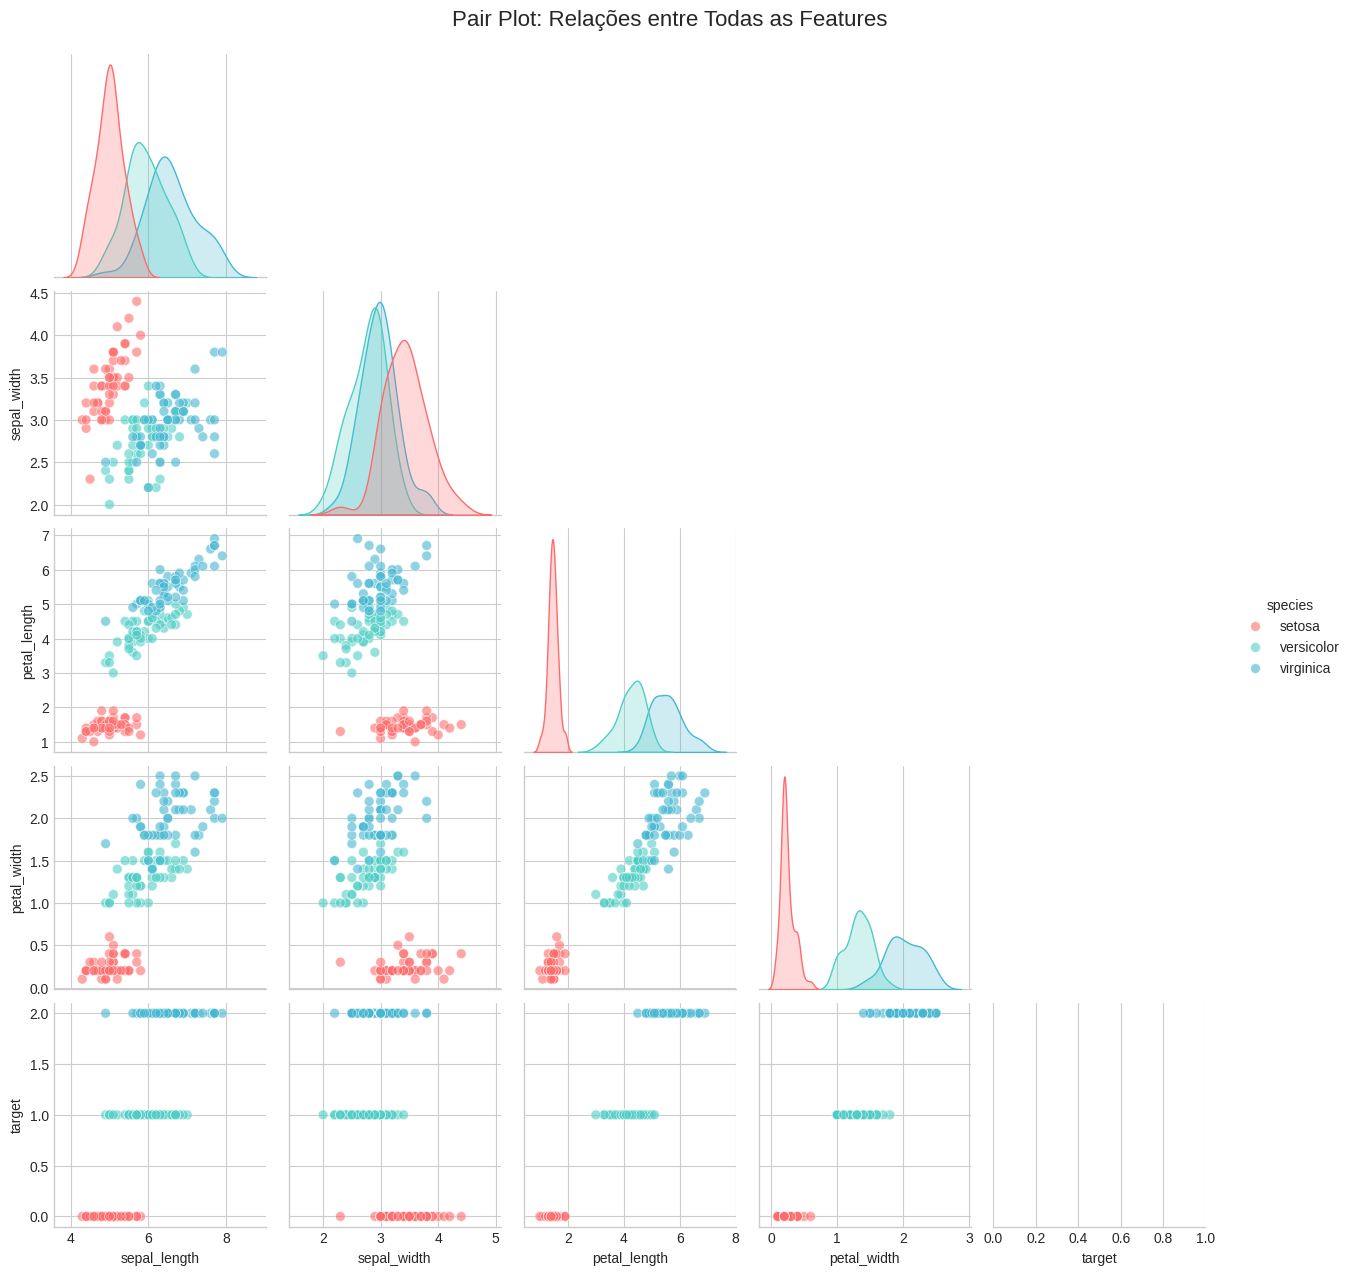

💡 Insights do Pair Plot:
   • Setosa é claramente separável das outras espécies
   • Versicolor e Virginica têm alguma sobreposição
   • Petal length/width são as features mais discriminativas


In [11]:
# Pair plot - visualização completa
sns.pairplot(df, hue='species', palette=colors, diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'white'},
             corner=True)
plt.suptitle('Pair Plot: Relações entre Todas as Features', fontsize=16, y=1.02)
plt.show()

print("💡 Insights do Pair Plot:")
print("   • Setosa é claramente separável das outras espécies")
print("   • Versicolor e Virginica têm alguma sobreposição")
print("   • Petal length/width são as features mais discriminativas")

---
## 4. Preparação dos Dados <a id='4-preparação-dos-dados'></a>

### 4.1 Divisão Treino/Validação/Teste

A divisão correta dos dados é **crucial** para avaliar a generalização do modelo.

```
┌─────────────────────────────────────────────────────────────┐
│                     DATASET COMPLETO                        │
├───────────────────────────────────┬─────────────────────────┤
│          TREINO (70%)             │       TESTE (30%)       │
│  ┌─────────────┬─────────────┐    │   (Avaliação final)     │
│  │ Train Fold  │  Val Fold   │    │                         │
│  │   (CV)      │    (CV)     │    │   NUNCA usar antes      │
│  └─────────────┴─────────────┘    │   do modelo final       │
└───────────────────────────────────┴─────────────────────────┘
```

**Regras de ouro:**
1. O conjunto de teste só deve ser usado UMA vez (avaliação final)
2. Use validação cruzada no conjunto de treino para tuning
3. `stratify=y` mantém a proporção das classes

In [12]:
# Separar features e target
X = df[features].values
y = df['target'].values

print(f"📐 Shape de X: {X.shape}")
print(f"📐 Shape de y: {y.shape}")

📐 Shape de X: (150, 4)
📐 Shape de y: (150,)


In [13]:
# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,          # 30% para teste
    random_state=RANDOM_STATE,
    stratify=y               # Mantém proporção das classes
)

print("📊 Divisão dos dados:")
print(f"   Treino: {len(X_train)} amostras ({len(X_train)/len(X):.1%})")
print(f"   Teste:  {len(X_test)} amostras ({len(X_test)/len(X):.1%})")

# Verificar estratificação
print("\n🎯 Distribuição das classes (verificando estratificação):")
print(f"   Original: {np.bincount(y)}")
print(f"   Treino:   {np.bincount(y_train)}")
print(f"   Teste:    {np.bincount(y_test)}")

📊 Divisão dos dados:
   Treino: 105 amostras (70.0%)
   Teste:  45 amostras (30.0%)

🎯 Distribuição das classes (verificando estratificação):
   Original: [50 50 50]
   Treino:   [35 35 35]
   Teste:    [15 15 15]


### 4.2 Padronização e Normalização

Diferentes técnicas de escalonamento para diferentes situações:

| Método | Fórmula | Quando usar |
|--------|---------|-------------|
| **StandardScaler** | $z = \frac{x - \mu}{\sigma}$ | Dados ~normais, SVM, Redes Neurais |
| **MinMaxScaler** | $z = \frac{x - x_{min}}{x_{max} - x_{min}}$ | Quando precisa de range [0,1] |
| **RobustScaler** | $z = \frac{x - Q_2}{Q_3 - Q_1}$ | Dados com muitos outliers |

⚠️ **IMPORTANTE:** Sempre fit no treino, transform no teste!

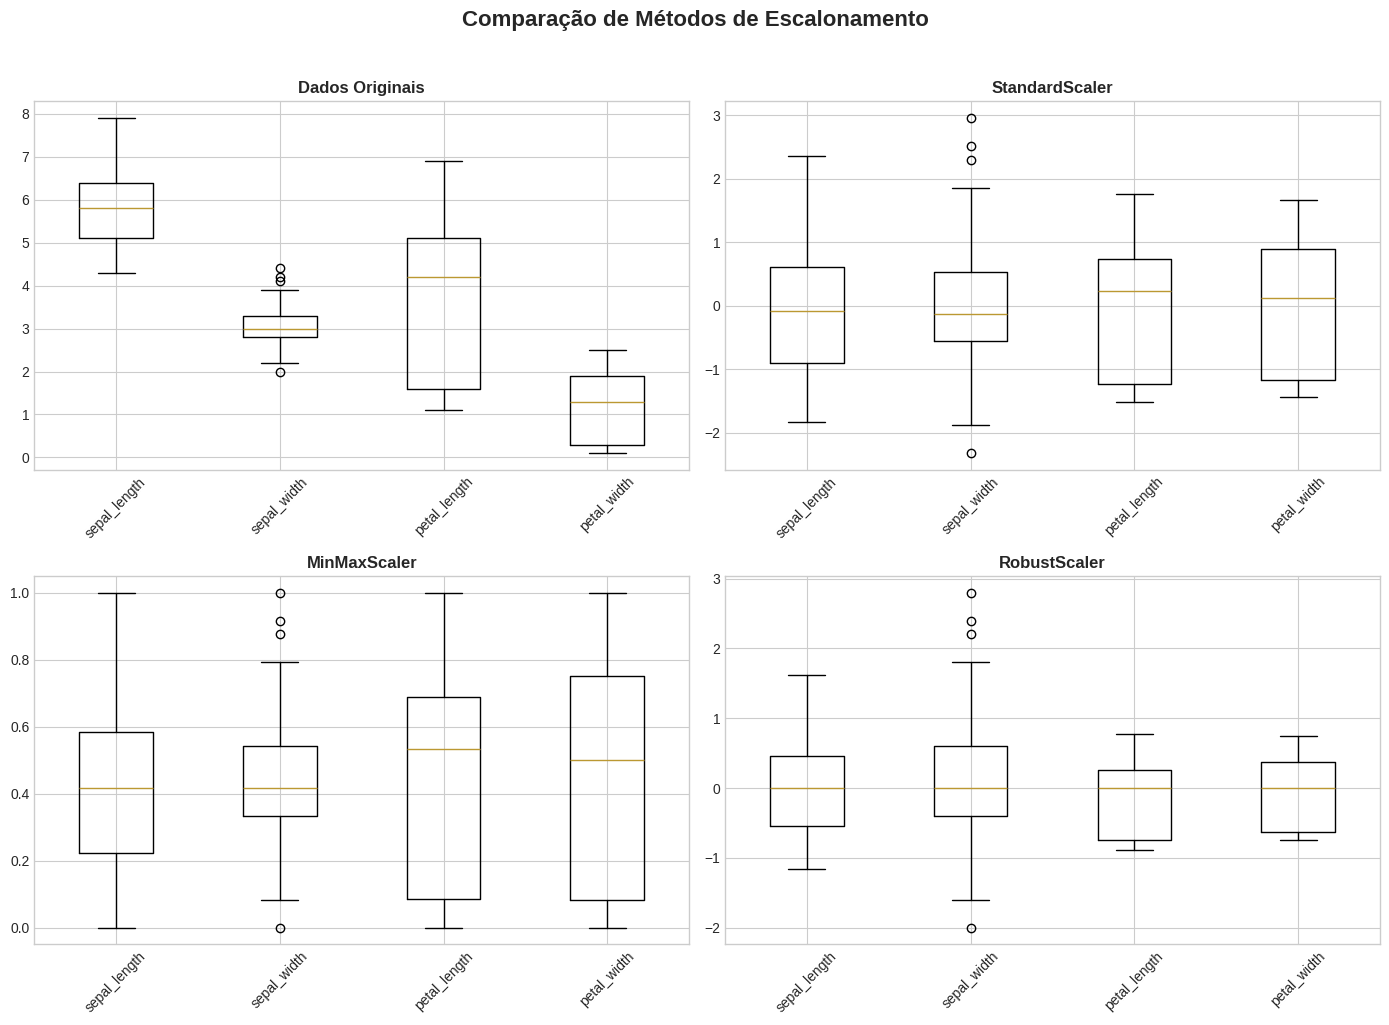

In [14]:
# Demonstrar os 3 tipos de escalonamento
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Visualizar o efeito de cada scaler
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
axes[0, 0].boxplot([X_train[:, i] for i in range(4)], labels=features)
axes[0, 0].set_title('Dados Originais', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Cada scaler
for ax, (name, scaler) in zip(axes.flat[1:], scalers.items()):
    X_scaled = scaler.fit_transform(X_train)
    ax.boxplot([X_scaled[:, i] for i in range(4)], labels=features)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Comparação de Métodos de Escalonamento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Usaremos StandardScaler (padrão para a maioria dos casos)
scaler = StandardScaler()

# CORRETO: fit apenas no treino
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # usa parâmetros do treino

print("✅ Dados padronizados com StandardScaler")
print("\n📊 Estatísticas após padronização (treino):")
print(f"   Média:  {X_train_scaled.mean(axis=0).round(4)}")
print(f"   Desvio: {X_train_scaled.std(axis=0).round(4)}")

✅ Dados padronizados com StandardScaler

📊 Estatísticas após padronização (treino):
   Média:  [ 0. -0. -0. -0.]
   Desvio: [1. 1. 1. 1.]


### 4.3 Feature Engineering

Feature Engineering é a arte de criar novas features a partir das existentes para melhorar o poder preditivo do modelo.

**Técnicas comuns:**
1. **Polynomial Features** — cria termos polinomiais e interações
2. **Binning** — discretiza variáveis contínuas
3. **Razões/Proporções** — combina features existentes
4. **Transformações** — log, sqrt, etc.

In [16]:
# Criar features derivadas manualmente
df_eng = df.copy()

# Razões entre dimensões
df_eng['sepal_ratio'] = df_eng['sepal_length'] / df_eng['sepal_width']
df_eng['petal_ratio'] = df_eng['petal_length'] / df_eng['petal_width']

# Áreas aproximadas
df_eng['sepal_area'] = df_eng['sepal_length'] * df_eng['sepal_width']
df_eng['petal_area'] = df_eng['petal_length'] * df_eng['petal_width']

# Proporção pétala/sépala
df_eng['petal_sepal_length_ratio'] = df_eng['petal_length'] / df_eng['sepal_length']
df_eng['petal_sepal_width_ratio'] = df_eng['petal_width'] / df_eng['sepal_width']

print("🔧 Novas features criadas:")
new_features = ['sepal_ratio', 'petal_ratio', 'sepal_area', 'petal_area',
                'petal_sepal_length_ratio', 'petal_sepal_width_ratio']
for f in new_features:
    print(f"   • {f}")

df_eng[new_features].describe().round(2)

🔧 Novas features criadas:
   • sepal_ratio
   • petal_ratio
   • sepal_area
   • petal_area
   • petal_sepal_length_ratio
   • petal_sepal_width_ratio


,sepal_ratio,petal_ratio,sepal_area,petal_area,petal_sepal_length_ratio,petal_sepal_width_ratio
count,150.00,150.00,150.00,150.00,150.00,150.00
mean,1.95,4.31,17.82,5.79,0.62,0.41
std,0.40,2.49,3.36,4.71,0.24,0.26
min,1.27,2.12,10.00,0.11,0.21,0.02
25%,1.55,2.80,15.66,0.42,0.31,0.09
50%,2.03,3.30,17.66,5.62,0.71,0.47
75%,2.22,4.67,20.32,9.69,0.81,0.62
max,2.96,15.00,30.02,15.87,0.95,0.88


In [17]:
# Polynomial Features (automático)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_example = poly.fit_transform(X_train[:5])

print("🔢 Polynomial Features (degree=2, interaction_only=True):")
print(f"   Features originais: {X_train.shape[1]}")
print(f"   Features após poly: {X_poly_example.shape[1]}")
print(f"\n   Nomes: {poly.get_feature_names_out(features)}")

🔢 Polynomial Features (degree=2, interaction_only=True):
   Features originais: 4
   Features após poly: 10

   Nomes: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width'
 'sepal_length sepal_width' 'sepal_length petal_length'
 'sepal_length petal_width' 'sepal_width petal_length'
 'sepal_width petal_width' 'petal_length petal_width']


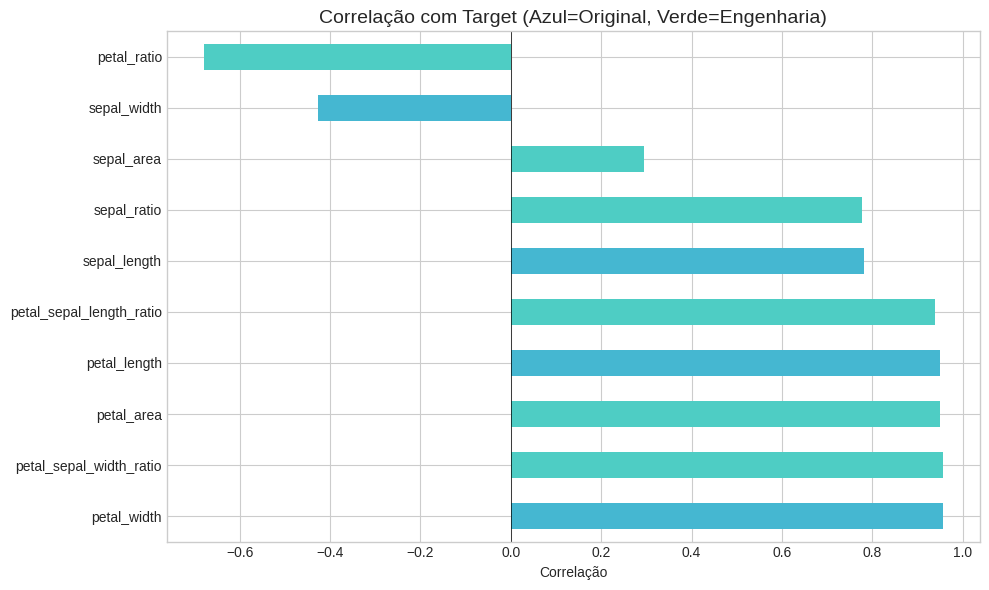

💡 Feature engineering pode melhorar ou não o modelo - sempre validar!


In [18]:
# Correlação das novas features com o target
all_features = features + new_features
corr_new = df_eng[all_features + ['target']].corr()['target'][:-1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors_corr = ['#4ECDC4' if f in new_features else '#45B7D1' for f in corr_new.index]
corr_new.plot(kind='barh', color=colors_corr)
plt.title('Correlação com Target (Azul=Original, Verde=Engenharia)', fontsize=14)
plt.xlabel('Correlação')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("💡 Feature engineering pode melhorar ou não o modelo - sempre validar!")

---
## 5. Fundamentos: Overfitting vs Underfitting <a id='5-fundamentos-overfitting-vs-underfitting'></a>

### O Dilema Viés-Variância

```
       UNDERFITTING              GOOD FIT                OVERFITTING
       (Alto Viés)           (Balanceado)            (Alta Variância)
    
         ┌───┐                  ┌───┐                    ┌───┐
         │   │              ∿∿∿∿│   │∿∿∿∿            ∿∿∿∿∿│∿∿∿│∿∿∿∿∿
    ─────┼───┼─────        ─────┼───┼─────          ─────┼───┼─────
         │   │                  │   │                    │   │
         └───┘                  └───┘                    └───┘
    
    Modelo muito             Modelo captura           Modelo "decora"
    simples                  padrão real              o ruído
    
    Train Error: Alto        Train Error: Baixo       Train Error: Muito baixo
    Test Error: Alto         Test Error: Baixo        Test Error: Alto
```

### Como detectar?

| Situação | Erro Treino | Erro Teste | Diagnóstico |
|----------|-------------|------------|-------------|
| Ambos altos | Alto | Alto | Underfitting |
| Treino baixo, teste alto | Baixo | Alto | Overfitting |
| Ambos baixos | Baixo | Baixo | ✅ Bom fit |

In [19]:
# Demonstração visual de overfitting vs underfitting
# Usando curvas de aprendizado (Learning Curves)

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    """Plota curva de aprendizado para diagnosticar over/underfitting"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.1, color='#4ECDC4')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                     alpha=0.1, color='#FF6B6B')
    plt.plot(train_sizes, train_mean, 'o-', color='#4ECDC4', label='Treino')
    plt.plot(train_sizes, test_mean, 'o-', color='#FF6B6B', label='Validação')
    plt.xlabel('Tamanho do conjunto de treino')
    plt.ylabel('Acurácia')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    return train_mean[-1], test_mean[-1]

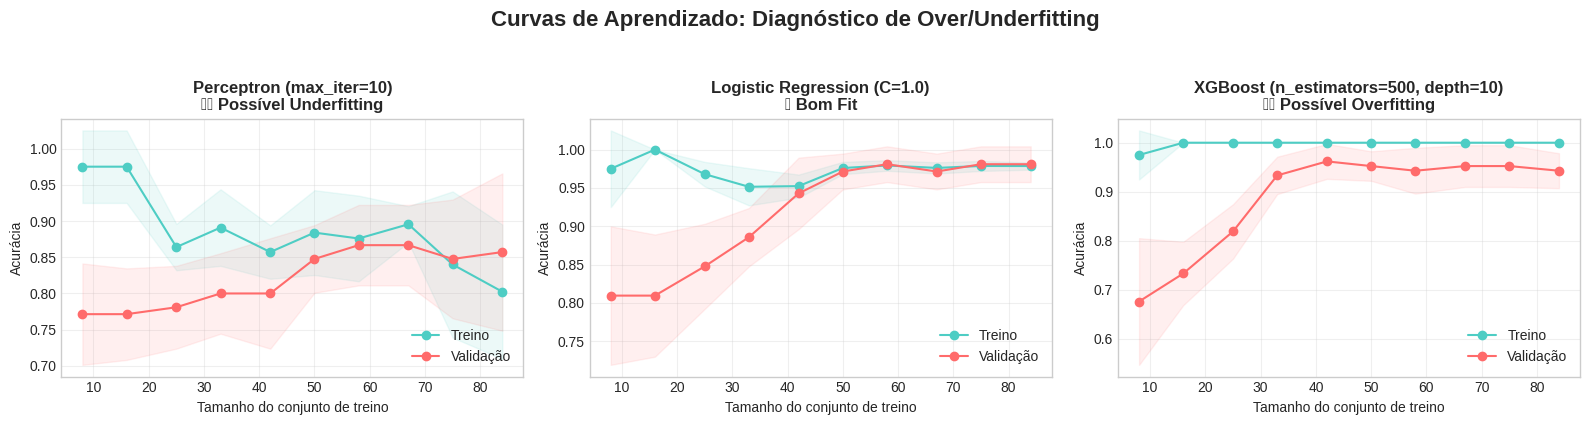

💡 Como interpretar:
   • Gap grande entre treino e validação → Overfitting
   • Ambas as curvas baixas → Underfitting
   • Curvas convergindo em valor alto → Bom fit


In [20]:
# Curvas de aprendizado para diferentes complexidades
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Modelo muito simples (Underfitting)
plt.sca(axes[0])
simple_model = Perceptron(max_iter=10, tol=1e-1)  # pouquíssimas iterações
plot_learning_curve(simple_model, 'Perceptron (max_iter=10)\n⚠️ Possível Underfitting',
                    X_train_scaled, y_train)

# Modelo balanceado
plt.sca(axes[1])
balanced_model = LogisticRegression(C=1.0, max_iter=1000)
plot_learning_curve(balanced_model, 'Logistic Regression (C=1.0)\n✅ Bom Fit',
                    X_train_scaled, y_train)

# Modelo complexo (potencial Overfitting)
plt.sca(axes[2])
complex_model = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.3,
                              random_state=RANDOM_STATE, verbosity=0)
plot_learning_curve(complex_model, 'XGBoost (n_estimators=500, depth=10)\n⚠️ Possível Overfitting',
                    X_train_scaled, y_train)

plt.suptitle('Curvas de Aprendizado: Diagnóstico de Over/Underfitting', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("💡 Como interpretar:")
print("   • Gap grande entre treino e validação → Overfitting")
print("   • Ambas as curvas baixas → Underfitting")
print("   • Curvas convergindo em valor alto → Bom fit")

---
## 6. Modelo 1: Perceptron <a id='6-modelo-1-perceptron'></a>

### Teoria Detalhada

O **Perceptron** é o algoritmo mais fundamental de redes neurais, proposto por Frank Rosenblatt em 1958.

#### Arquitetura

```
    Entradas        Pesos          Soma           Ativação        Saída
    
      x₁  ─────────  w₁  ─────┐
                              │
      x₂  ─────────  w₂  ─────┼──── Σ ──────── step(z) ──────── ŷ
                              │
      x₃  ─────────  w₃  ─────┘
                              │
       1  ─────────  b  ──────┘ (bias)
    
    z = w₁x₁ + w₂x₂ + w₃x₃ + b
    
    step(z) = { 1 se z ≥ 0
              { 0 se z < 0
```

#### Algoritmo de Aprendizado

```
Para cada amostra (x, y):
    1. Calcular previsão: ŷ = step(w·x + b)
    2. Se ŷ ≠ y (erro):
       - Atualizar pesos: w = w + η(y - ŷ)x
       - Atualizar bias:  b = b + η(y - ŷ)
    3. Repetir até convergir ou max_iter
```

#### Limitações

O Perceptron **só converge** se os dados forem **linearmente separáveis**. Famosamente, não consegue resolver o problema XOR.

| ✅ Vantagens | ❌ Desvantagens |
|-------------|----------------|
| Simples e rápido | Só funciona para dados linearmente separáveis |
| Interpretável | Não fornece probabilidades |
| Base para redes neurais | Sensível a outliers |

In [21]:
# Criar e treinar o Perceptron
perceptron = Perceptron(
    max_iter=1000,       # Máximo de épocas (passagens pelo dataset)
    tol=1e-3,            # Tolerância para critério de parada
    eta0=1.0,            # Taxa de aprendizado inicial
    random_state=RANDOM_STATE,
    verbose=0
)

# Treinar
perceptron.fit(X_train_scaled, y_train)

# Previsões
y_pred_train_perceptron = perceptron.predict(X_train_scaled)
y_pred_test_perceptron = perceptron.predict(X_test_scaled)

# Métricas
acc_train_perceptron = accuracy_score(y_train, y_pred_train_perceptron)
acc_test_perceptron = accuracy_score(y_test, y_pred_test_perceptron)

print("═" * 50)
print("🤖 PERCEPTRON - Resultados")
print("═" * 50)
print(f"📊 Acurácia Treino: {acc_train_perceptron:.2%}")
print(f"📊 Acurácia Teste:  {acc_test_perceptron:.2%}")
print(f"📉 Gap (Treino-Teste): {acc_train_perceptron - acc_test_perceptron:.2%}")
print(f"\n🔢 Número de iterações: {perceptron.n_iter_}")

══════════════════════════════════════════════════
🤖 PERCEPTRON - Resultados
══════════════════════════════════════════════════
📊 Acurácia Treino: 88.57%
📊 Acurácia Teste:  80.00%
📉 Gap (Treino-Teste): 8.57%

🔢 Número de iterações: 13


In [22]:
# Analisar pesos aprendidos
print("🔍 Análise dos Pesos do Perceptron:\n")
print("Cada classe tem seu próprio vetor de pesos (One-vs-Rest):\n")

weights_df = pd.DataFrame(
    perceptron.coef_,
    columns=features,
    index=iris.target_names
).round(4)
weights_df['bias'] = perceptron.intercept_

print(weights_df)
print("\n💡 Pesos maiores (em módulo) indicam features mais importantes para cada classe")

🔍 Análise dos Pesos do Perceptron:

Cada classe tem seu próprio vetor de pesos (One-vs-Rest):

            sepal_length  sepal_width  petal_length  petal_width  bias
setosa           -0.4968       1.0005       -1.5856      -1.5433  -1.0
versicolor       -0.8461      -3.6147        4.1592      -2.1895  -1.0
virginica         1.0324      -1.2265        4.3244       5.4866  -8.0

💡 Pesos maiores (em módulo) indicam features mais importantes para cada classe


In [23]:
# Relatório de classificação
print("📋 Relatório de Classificação - Perceptron:\n")
print(classification_report(y_test, y_pred_test_perceptron, target_names=iris.target_names))

📋 Relatório de Classificação - Perceptron:

              precision    recall  f1-score   support

      setosa       0.88      1.00      0.94        15
  versicolor       0.65      0.87      0.74        15
   virginica       1.00      0.53      0.70        15

    accuracy                           0.80        45
   macro avg       0.84      0.80      0.79        45
weighted avg       0.84      0.80      0.79        45



---
## 7. Modelo 2: Regressão Logística <a id='7-modelo-2-regressão-logística'></a>

### Teoria Detalhada

A **Regressão Logística** é uma extensão do Perceptron que produz **probabilidades** usando a função sigmoid.

#### Função Sigmoid (caso binário)

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

```
    1.0 ┤                    ●●●●●●●●●●
        │                ●●●
        │              ●●
    0.5 ┤            ●
        │          ●●
        │       ●●●
    0.0 ┤●●●●●●●
        └─────────────────────────────
               -∞        0        +∞
                         z
```

#### Função de Custo (Log-Loss / Cross-Entropy)

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(\hat{y}^{(i)}) + (1-y^{(i)})\log(1-\hat{y}^{(i)})]$$

#### Multiclasse: Softmax

Para problemas com mais de 2 classes, usa-se a função **Softmax**:

$$P(y=k|x) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

Isso garante que as probabilidades somem 1.

| ✅ Vantagens | ❌ Desvantagens |
|-------------|----------------|
| Fornece probabilidades | Assume linearidade |
| Regularização embutida | Pode não capturar relações complexas |
| Convergência garantida | Sensível a multicolinearidade |
| Muito interpretável | |

In [24]:
# Criar e treinar Regressão Logística
log_reg = LogisticRegression(
    penalty='l2',           # Regularização L2 (Ridge)
    C=1.0,                  # Inverso da força de regularização
    solver='lbfgs',         # Algoritmo de otimização
    multi_class='multinomial',  # Softmax para multiclasse
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Treinar
log_reg.fit(X_train_scaled, y_train)

# Previsões
y_pred_train_logreg = log_reg.predict(X_train_scaled)
y_pred_test_logreg = log_reg.predict(X_test_scaled)

# Probabilidades
y_proba_test_logreg = log_reg.predict_proba(X_test_scaled)

# Métricas
acc_train_logreg = accuracy_score(y_train, y_pred_train_logreg)
acc_test_logreg = accuracy_score(y_test, y_pred_test_logreg)

print("═" * 50)
print("📊 REGRESSÃO LOGÍSTICA - Resultados")
print("═" * 50)
print(f"📊 Acurácia Treino: {acc_train_logreg:.2%}")
print(f"📊 Acurácia Teste:  {acc_test_logreg:.2%}")
print(f"📉 Gap (Treino-Teste): {acc_train_logreg - acc_test_logreg:.2%}")

══════════════════════════════════════════════════
📊 REGRESSÃO LOGÍSTICA - Resultados
══════════════════════════════════════════════════
📊 Acurácia Treino: 98.10%
📊 Acurácia Teste:  91.11%
📉 Gap (Treino-Teste): 6.98%


In [25]:
# Visualizar probabilidades
print("🎲 Probabilidades previstas (primeiras 10 amostras de teste):\n")

proba_df = pd.DataFrame(
    y_proba_test_logreg[:10],
    columns=[f'P({name})' for name in iris.target_names]
).round(4)
proba_df['Previsão'] = [iris.target_names[i] for i in y_pred_test_logreg[:10]]
proba_df['Real'] = [iris.target_names[i] for i in y_test[:10]]
proba_df['Confiança'] = y_proba_test_logreg[:10].max(axis=1).round(4)
proba_df['Correto?'] = ['✓' if p == r else '✗' for p, r in zip(proba_df['Previsão'], proba_df['Real'])]

proba_df

🎲 Probabilidades previstas (primeiras 10 amostras de teste):



,P(setosa),P(versicolor),P(virginica),Previsão,Real,Confiança,Correto?
0,0.0000,0.1014,0.8985,virginica,virginica,0.8985,✓
1,0.0141,0.7894,0.1964,versicolor,versicolor,0.7894,✓
2,0.0036,0.6202,0.3762,versicolor,virginica,0.6202,✗
3,0.0218,0.6292,0.3490,versicolor,versicolor,0.6292,✓
4,0.0052,0.3846,0.6103,virginica,virginica,0.6103,✓
5,0.0000,0.0224,0.9775,virginica,virginica,0.9775,✓
6,0.0158,0.9147,0.0696,versicolor,versicolor,0.9147,✓
7,0.0337,0.9385,0.0278,versicolor,versicolor,0.9385,✓
8,0.9377,0.0623,0.0000,setosa,setosa,0.9377,✓
9,0.0001,0.0548,0.9451,virginica,virginica,0.9451,✓


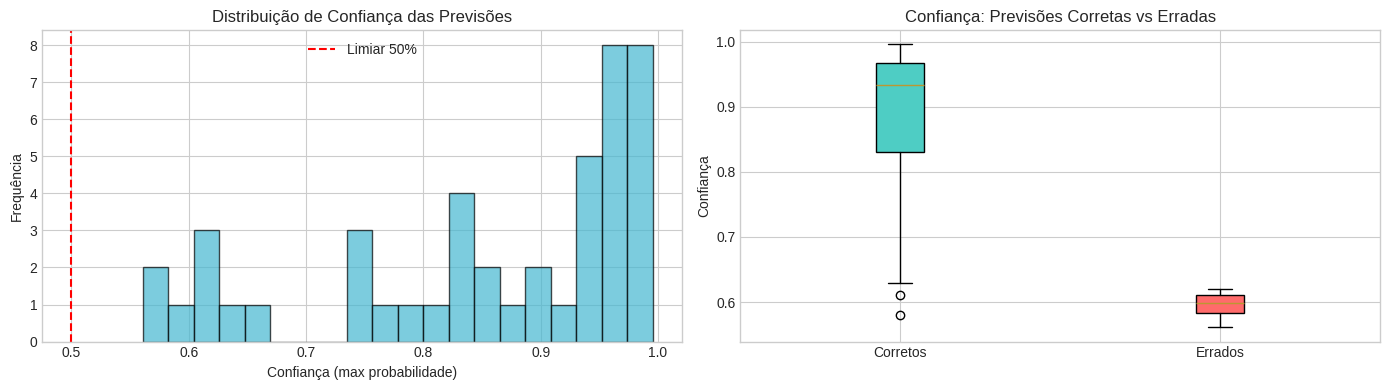

💡 Confiança média nas previsões corretas: 87.78%
💡 Confiança média nas previsões erradas: 59.49%


In [26]:
# Distribuição de confiança
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histograma de confiança
max_probas = y_proba_test_logreg.max(axis=1)
axes[0].hist(max_probas, bins=20, edgecolor='black', color='#45B7D1', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Limiar 50%')
axes[0].set_xlabel('Confiança (max probabilidade)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Confiança das Previsões', fontsize=12)
axes[0].legend()

# Confiança por acerto/erro
corretos = max_probas[y_pred_test_logreg == y_test]
errados = max_probas[y_pred_test_logreg != y_test]

data_conf = [corretos, errados] if len(errados) > 0 else [corretos]
labels_conf = ['Corretos', 'Errados'] if len(errados) > 0 else ['Corretos']
colors_conf = ['#4ECDC4', '#FF6B6B']

bp = axes[1].boxplot(data_conf, labels=labels_conf, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_conf[:len(data_conf)]):
    patch.set_facecolor(color)
axes[1].set_ylabel('Confiança')
axes[1].set_title('Confiança: Previsões Corretas vs Erradas', fontsize=12)

plt.tight_layout()
plt.show()

print(f"💡 Confiança média nas previsões corretas: {corretos.mean():.2%}")
if len(errados) > 0:
    print(f"💡 Confiança média nas previsões erradas: {errados.mean():.2%}")

### 7.1 Regularização L1 e L2

A regularização adiciona uma penalidade aos pesos para evitar overfitting.

| Tipo | Fórmula | Efeito | Quando usar |
|------|---------|--------|--------------|
| **L1 (Lasso)** | $\lambda\sum|w_i|$ | Zera pesos → Feature selection | Muitas features, suspeita de irrelevantes |
| **L2 (Ridge)** | $\lambda\sum w_i^2$ | Reduz pesos → Suaviza | Multicolinearidade, default |
| **Elastic Net** | $\alpha L1 + (1-\alpha)L2$ | Combinação | Quando ambos são úteis |

O parâmetro **C** é o inverso da força de regularização:
- C grande → pouca regularização → pode overfittar
- C pequeno → muita regularização → pode underfittar

In [27]:
# Comparar L1 vs L2 vs sem regularização
regularizations = {
    'Sem regularização (C=1e10)': LogisticRegression(C=1e10, max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE),
    'L2 / Ridge (C=1.0)': LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE),
    'L2 / Ridge (C=0.1)': LogisticRegression(penalty='l2', C=0.1, max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE),
    'L1 / Lasso (C=1.0)': LogisticRegression(penalty='l1', C=1.0, max_iter=1000, solver='saga', random_state=RANDOM_STATE),
}

print("📊 Comparação de Regularizações:\n")
print(f"{'Regularização':<30} {'Acc Treino':>12} {'Acc Teste':>12} {'# Coefs ≠ 0':>14}")
print("─" * 70)

for name, model in regularizations.items():
    model.fit(X_train_scaled, y_train)
    acc_tr = accuracy_score(y_train, model.predict(X_train_scaled))
    acc_te = accuracy_score(y_test, model.predict(X_test_scaled))
    nonzero = np.sum(np.abs(model.coef_) > 1e-6)
    print(f"{name:<30} {acc_tr:>12.2%} {acc_te:>12.2%} {nonzero:>14}")

📊 Comparação de Regularizações:

Regularização                    Acc Treino    Acc Teste    # Coefs ≠ 0
──────────────────────────────────────────────────────────────────────
Sem regularização (C=1e10)          100.00%       88.89%             12
L2 / Ridge (C=1.0)                   98.10%       91.11%             12
L2 / Ridge (C=0.1)                   93.33%       84.44%             12
L1 / Lasso (C=1.0)                   98.10%       91.11%              6


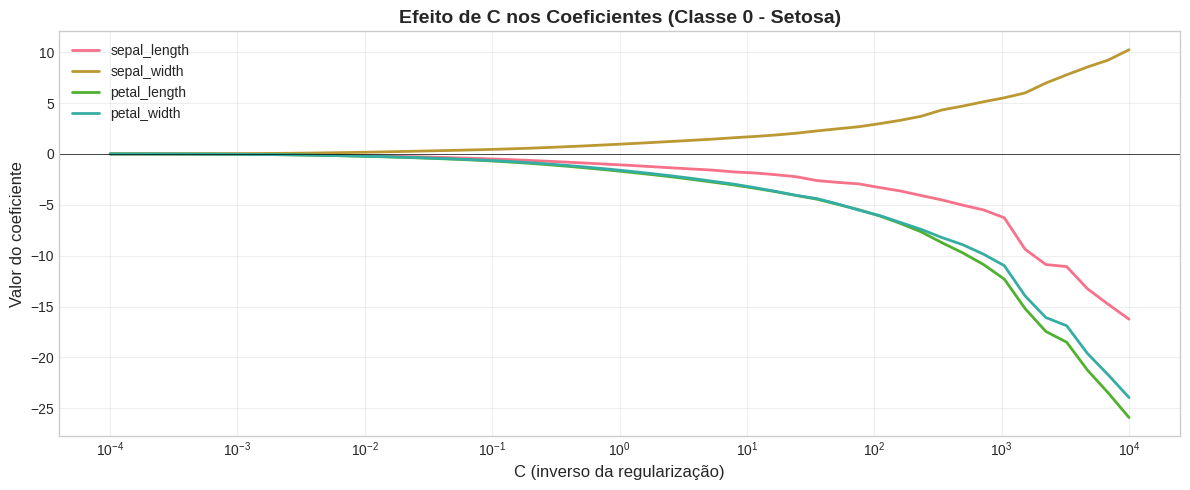

💡 C pequeno → regularização forte → coeficientes próximos de zero
💡 C grande → pouca regularização → coeficientes podem crescer livremente


In [28]:
# Visualizar como C afeta os coeficientes
C_values = np.logspace(-4, 4, 50)
coefs = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=5000, solver='lbfgs', random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_[0])  # Pega coeficientes da primeira classe

coefs = np.array(coefs)

plt.figure(figsize=(12, 5))
for i, feature in enumerate(features):
    plt.plot(C_values, coefs[:, i], label=feature, linewidth=2)

plt.xscale('log')
plt.xlabel('C (inverso da regularização)', fontsize=12)
plt.ylabel('Valor do coeficiente', fontsize=12)
plt.title('Efeito de C nos Coeficientes (Classe 0 - Setosa)', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 C pequeno → regularização forte → coeficientes próximos de zero")
print("💡 C grande → pouca regularização → coeficientes podem crescer livremente")

---
## 8. Modelo 3: XGBoost <a id='8-modelo-3-xgboost'></a>

### Teoria Detalhada

**XGBoost** (eXtreme Gradient Boosting) é um algoritmo de ensemble que combina múltiplas árvores de decisão de forma sequencial.

#### Conceito de Boosting

```
    Dados ────► Árvore₁ ────► Resíduo₁ ────► Árvore₂ ────► Resíduo₂ ────► ... ────► Predição Final
                   │                            │
                   └── Foca nos erros ──────────┘
                       da árvore anterior
```

#### Matemática Simplificada

$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

Onde:
- $F_m(x)$ = modelo após m árvores
- $\eta$ = taxa de aprendizado (learning rate)
- $h_m(x)$ = nova árvore que corrige os erros

#### Diferenciais do XGBoost

1. **Regularização:** L1 e L2 para evitar overfitting
2. **Poda inteligente:** Para quando não há mais ganho
3. **Tratamento de missing:** Aprende direção ótima
4. **Paralelização:** Treino muito rápido

#### Principais Hiperparâmetros

| Parâmetro | Descrição | Default | Tuning |
|-----------|-----------|---------|--------|
| `n_estimators` | Número de árvores | 100 | Mais = melhor (até certo ponto) |
| `max_depth` | Profundidade máxima | 6 | Menor = menos overfitting |
| `learning_rate` | Taxa de aprendizado | 0.3 | Menor = mais robusto |
| `subsample` | % de amostras por árvore | 1.0 | 0.5-0.9 reduz overfitting |
| `colsample_bytree` | % de features por árvore | 1.0 | 0.5-0.9 reduz overfitting |
| `reg_alpha` | Regularização L1 | 0 | Aumentar se overfit |
| `reg_lambda` | Regularização L2 | 1 | Aumentar se overfit |

In [29]:
# Criar e treinar XGBoost
xgb = XGBClassifier(
    n_estimators=100,        # Número de árvores
    max_depth=4,             # Profundidade máxima
    learning_rate=0.1,       # Taxa de aprendizado
    subsample=0.8,           # 80% das amostras por árvore
    colsample_bytree=0.8,    # 80% das features por árvore
    reg_alpha=0.1,           # Regularização L1
    reg_lambda=1.0,          # Regularização L2
    eval_metric='mlogloss',  # Métrica para multiclasse
    random_state=RANDOM_STATE,
    verbosity=0
)

# Treinar
xgb.fit(X_train_scaled, y_train)

# Previsões
y_pred_train_xgb = xgb.predict(X_train_scaled)
y_pred_test_xgb = xgb.predict(X_test_scaled)
y_proba_test_xgb = xgb.predict_proba(X_test_scaled)

# Métricas
acc_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
acc_test_xgb = accuracy_score(y_test, y_pred_test_xgb)

print("═" * 50)
print("🚀 XGBOOST - Resultados")
print("═" * 50)
print(f"📊 Acurácia Treino: {acc_train_xgb:.2%}")
print(f"📊 Acurácia Teste:  {acc_test_xgb:.2%}")
print(f"📉 Gap (Treino-Teste): {acc_train_xgb - acc_test_xgb:.2%}")

══════════════════════════════════════════════════
🚀 XGBOOST - Resultados
══════════════════════════════════════════════════
📊 Acurácia Treino: 100.00%
📊 Acurácia Teste:  91.11%
📉 Gap (Treino-Teste): 8.89%


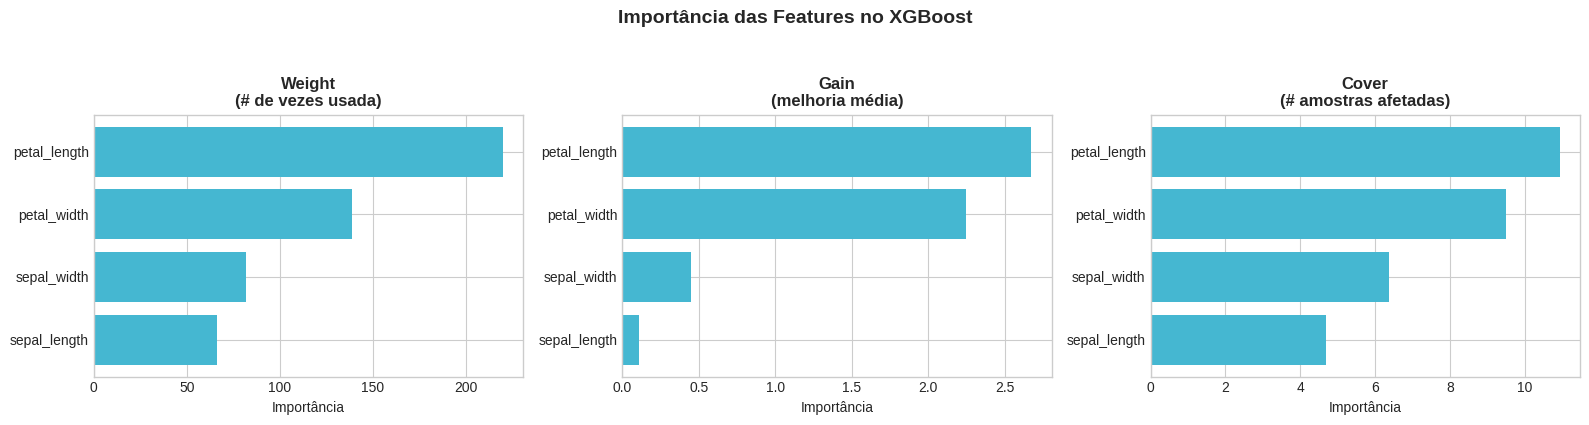

💡 Diferentes métricas podem dar rankings diferentes!
   - Weight: quantas vezes a feature foi usada em splits
   - Gain: ganho médio de informação quando usada
   - Cover: média de amostras afetadas quando usada


In [30]:
# Importância das features (3 métodos)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

importance_types = ['weight', 'gain', 'cover']
titles = [
    'Weight\n(# de vezes usada)',
    'Gain\n(melhoria média)',
    'Cover\n(# amostras afetadas)'
]

for ax, imp_type, title in zip(axes, importance_types, titles):
    importance = xgb.get_booster().get_score(importance_type=imp_type)
    if importance:
        imp_df = pd.DataFrame({
            'Feature': [features[int(k[1:])] for k in importance.keys()],
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=True)

        ax.barh(imp_df['Feature'], imp_df['Importance'], color='#45B7D1')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Importância')

plt.suptitle('Importância das Features no XGBoost', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("💡 Diferentes métricas podem dar rankings diferentes!")
print("   - Weight: quantas vezes a feature foi usada em splits")
print("   - Gain: ganho médio de informação quando usada")
print("   - Cover: média de amostras afetadas quando usada")

In [31]:
# Relatório de classificação
print("📋 Relatório de Classificação - XGBoost:\n")
print(classification_report(y_test, y_pred_test_xgb, target_names=iris.target_names))

📋 Relatório de Classificação - XGBoost:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



---
## 9. Validação Cruzada (Cross-Validation) <a id='9-validação-cruzada'></a>

### Por que usar?

Uma única divisão treino/teste pode dar resultados enganosos. A **validação cruzada** avalia o modelo em múltiplas divisões.

### K-Fold Cross-Validation

```
    Fold 1: [VAL][───────────TREINO───────────]
    Fold 2: [──][VAL][────────TREINO──────────]
    Fold 3: [────][VAL][───────TREINO─────────]
    Fold 4: [──────][VAL][─────TREINO─────────]
    Fold 5: [────────TREINO────────────][VAL ]
    
    Score final = média dos 5 scores
```

### Stratified K-Fold

Mantém a proporção das classes em cada fold — **essencial para classificação**.

In [32]:
# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Modelos para comparar
models = {
    'Baseline (Mais Frequente)': DummyClassifier(strategy='most_frequent'),
    'Perceptron': Perceptron(max_iter=1000, random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, verbosity=0)
}

print("📊 Validação Cruzada Estratificada (5-Fold):\n")
print(f"{'Modelo':<30} {'Média':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("─" * 72)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name:<30} {scores.mean():>10.2%} {scores.std():>10.2%} {scores.min():>10.2%} {scores.max():>10.2%}")

📊 Validação Cruzada Estratificada (5-Fold):

Modelo                              Média        Std        Min        Max
────────────────────────────────────────────────────────────────────────
Baseline (Mais Frequente)          33.33%      0.00%     33.33%     33.33%
Perceptron                         84.76%      5.55%     76.19%     90.48%
Logistic Regression                98.10%      2.33%     95.24%    100.00%
XGBoost                            95.24%      3.01%     90.48%    100.00%


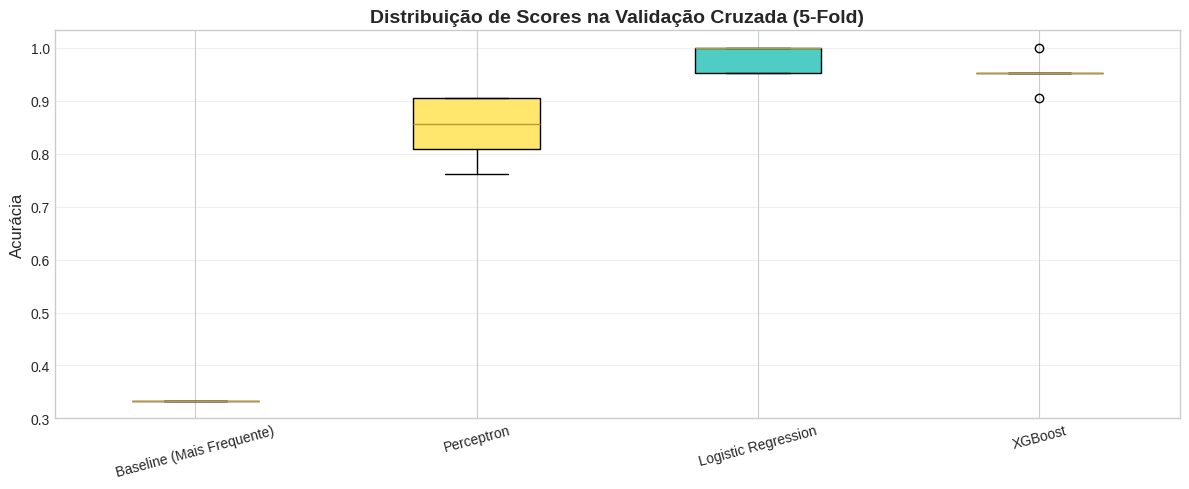

💡 Boxplots estreitos indicam modelo mais estável


In [33]:
# Visualizar distribuição dos scores
plt.figure(figsize=(12, 5))

positions = range(len(cv_results))
bp = plt.boxplot(
    cv_results.values(),
    positions=positions,
    patch_artist=True,
    labels=cv_results.keys()
)

colors_box = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#45B7D1']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)

plt.ylabel('Acurácia', fontsize=12)
plt.title('Distribuição de Scores na Validação Cruzada (5-Fold)', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Boxplots estreitos indicam modelo mais estável")

In [34]:
# Múltiplas métricas na validação cruzada
from sklearn.model_selection import cross_validate

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

print("📊 Múltiplas Métricas na Validação Cruzada (Logistic Regression):\n")

cv_multi = cross_validate(
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    X_train_scaled, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

metrics_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Treino (média)': [
        cv_multi['train_accuracy'].mean(),
        cv_multi['train_precision_macro'].mean(),
        cv_multi['train_recall_macro'].mean(),
        cv_multi['train_f1_macro'].mean()
    ],
    'Validação (média)': [
        cv_multi['test_accuracy'].mean(),
        cv_multi['test_precision_macro'].mean(),
        cv_multi['test_recall_macro'].mean(),
        cv_multi['test_f1_macro'].mean()
    ]
}).round(4)

metrics_df

📊 Múltiplas Métricas na Validação Cruzada (Logistic Regression):



,Métrica,Treino (média),Validação (média)
0,Accuracy,0.9786,0.9810
1,Precision,0.9787,0.9833
2,Recall,0.9786,0.9810
3,F1-Score,0.9786,0.9809


---
## 10. Tuning de Hiperparâmetros <a id='10-tuning-de-hiperparâmetros'></a>

### Estratégias

| Método | Descrição | Prós | Contras |
|--------|-----------|------|--------|
| **Grid Search** | Busca exaustiva | Encontra o melhor | Muito lento |
| **Random Search** | Amostragem aleatória | Mais rápido | Pode perder o ótimo |
| **Bayesian** | Otimização inteligente | Eficiente | Mais complexo |

### Grid Search

Testa **todas** as combinações de parâmetros.

In [35]:
# Grid Search para Logistic Regression
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']  # Único solver que suporta L1
}

grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=RANDOM_STATE),
    param_grid_logreg,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

print("🔍 Grid Search - Logistic Regression...")
grid_search_logreg.fit(X_train_scaled, y_train)

print(f"\n✅ Melhores hiperparâmetros: {grid_search_logreg.best_params_}")
print(f"📊 Melhor score CV: {grid_search_logreg.best_score_:.2%}")

🔍 Grid Search - Logistic Regression...

✅ Melhores hiperparâmetros: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
📊 Melhor score CV: 99.05%


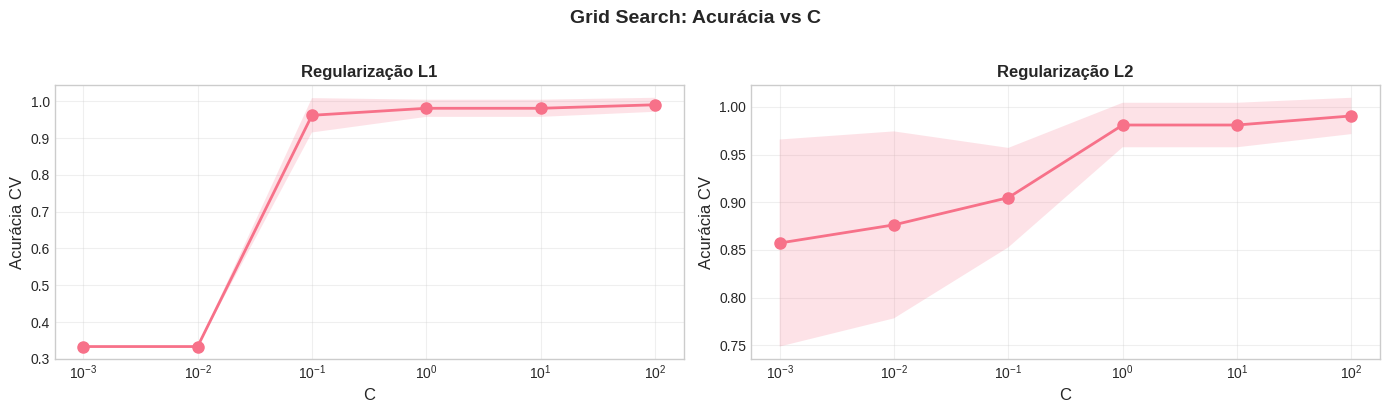

In [36]:
# Visualizar resultados do Grid Search
results_logreg = pd.DataFrame(grid_search_logreg.cv_results_)

# Pivot para heatmap
pivot_l1 = results_logreg[results_logreg['param_penalty'] == 'l1'].pivot(
    index='param_C', columns='param_penalty', values='mean_test_score'
)
pivot_l2 = results_logreg[results_logreg['param_penalty'] == 'l2'].pivot(
    index='param_C', columns='param_penalty', values='mean_test_score'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, penalty in zip(axes, ['l1', 'l2']):
    subset = results_logreg[results_logreg['param_penalty'] == penalty]
    ax.plot(subset['param_C'], subset['mean_test_score'], 'o-', linewidth=2, markersize=8)
    ax.fill_between(
        subset['param_C'],
        subset['mean_test_score'] - subset['std_test_score'],
        subset['mean_test_score'] + subset['std_test_score'],
        alpha=0.2
    )
    ax.set_xscale('log')
    ax.set_xlabel('C', fontsize=12)
    ax.set_ylabel('Acurácia CV', fontsize=12)
    ax.set_title(f'Regularização {penalty.upper()}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Grid Search: Acurácia vs C', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [37]:
# Randomized Search para XGBoost (mais eficiente)
from scipy.stats import uniform, randint

param_dist_xgb = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 2)
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, verbosity=0, eval_metric='mlogloss'),
    param_dist_xgb,
    n_iter=50,  # Número de combinações aleatórias
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)

print("🔍 Randomized Search - XGBoost (50 iterações)...")
random_search_xgb.fit(X_train_scaled, y_train)

print(f"\n✅ Melhores hiperparâmetros:")
for param, value in random_search_xgb.best_params_.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.4f}")
    else:
        print(f"   {param}: {value}")
print(f"\n📊 Melhor score CV: {random_search_xgb.best_score_:.2%}")

🔍 Randomized Search - XGBoost (50 iterações)...

✅ Melhores hiperparâmetros:
   colsample_bytree: 0.7498
   learning_rate: 0.2952
   max_depth: 4
   n_estimators: 121
   reg_alpha: 0.5987
   reg_lambda: 0.8120
   subsample: 0.6624

📊 Melhor score CV: 95.24%


In [38]:
# Guardar melhores modelos
best_logreg = grid_search_logreg.best_estimator_
best_xgb = random_search_xgb.best_estimator_

print("✅ Melhores modelos salvos:")
print(f"   - best_logreg: {best_logreg}")
print(f"   - best_xgb: XGBClassifier com parâmetros otimizados")

✅ Melhores modelos salvos:
   - best_logreg: LogisticRegression(C=100, max_iter=5000, penalty='l1', random_state=42,
                   solver='saga')
   - best_xgb: XGBClassifier com parâmetros otimizados


---
## 11. Métricas Avançadas: ROC, AUC e Curvas PR <a id='11-métricas-avançadas'></a>

### Além da Acurácia

Acurácia pode ser enganosa, especialmente com classes desbalanceadas.

### Curva ROC (Receiver Operating Characteristic)

Plota **Taxa de Verdadeiros Positivos (TPR/Recall)** vs **Taxa de Falsos Positivos (FPR)**.

- **AUC = 1.0:** Classificador perfeito
- **AUC = 0.5:** Equivalente a chute aleatório
- **AUC < 0.5:** Pior que aleatório

### Curva Precision-Recall

Mais informativa quando as classes são desbalanceadas.

- **Precision:** Dos que previ positivo, quantos realmente são?
- **Recall:** Dos que são positivos, quantos eu encontrei?

In [39]:
# Preparar para curvas ROC multiclasse (One-vs-Rest)
# Binarizar os labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Obter probabilidades dos melhores modelos
y_proba_logreg = best_logreg.predict_proba(X_test_scaled)
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)

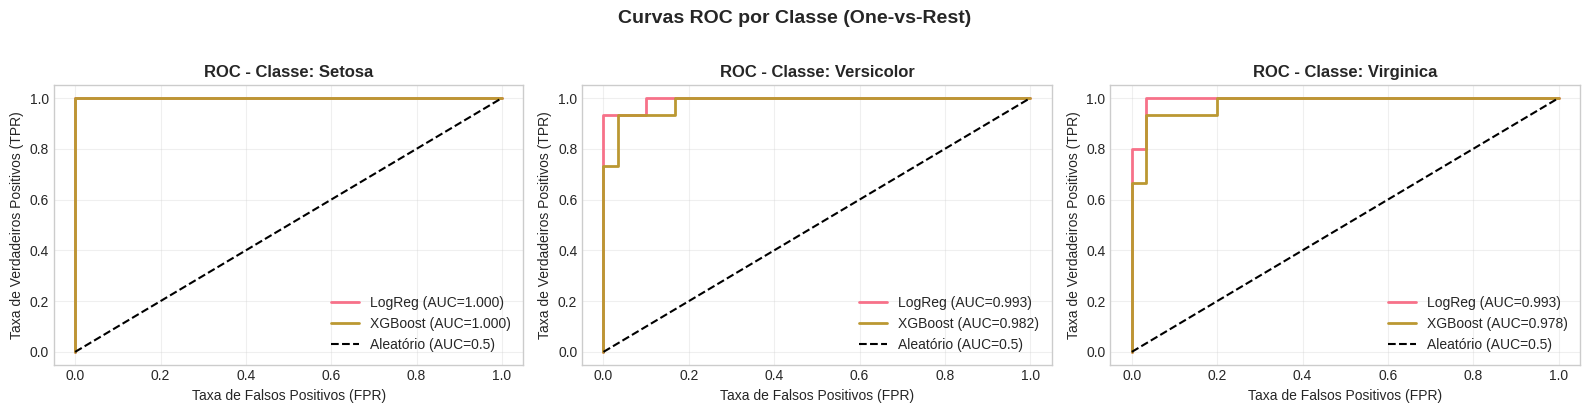

In [40]:
# Curvas ROC para cada classe
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (class_name, ax) in enumerate(zip(iris.target_names, axes)):
    # Logistic Regression
    fpr_lr, tpr_lr, _ = roc_curve(y_test_bin[:, i], y_proba_logreg[:, i])
    auc_lr = roc_auc_score(y_test_bin[:, i], y_proba_logreg[:, i])

    # XGBoost
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    auc_xgb = roc_auc_score(y_test_bin[:, i], y_proba_xgb[:, i])

    # Plotar
    ax.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})', linewidth=2)
    ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC=0.5)')

    ax.set_xlabel('Taxa de Falsos Positivos (FPR)')
    ax.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    ax.set_title(f'ROC - Classe: {class_name.title()}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Curvas ROC por Classe (One-vs-Rest)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [41]:
# AUC médio (macro e weighted)
auc_macro_logreg = roc_auc_score(y_test_bin, y_proba_logreg, multi_class='ovr', average='macro')
auc_macro_xgb = roc_auc_score(y_test_bin, y_proba_xgb, multi_class='ovr', average='macro')

print("📊 AUC-ROC Macro (média das classes):")
print(f"   Logistic Regression: {auc_macro_logreg:.4f}")
print(f"   XGBoost:             {auc_macro_xgb:.4f}")

📊 AUC-ROC Macro (média das classes):
   Logistic Regression: 0.9956
   XGBoost:             0.9867


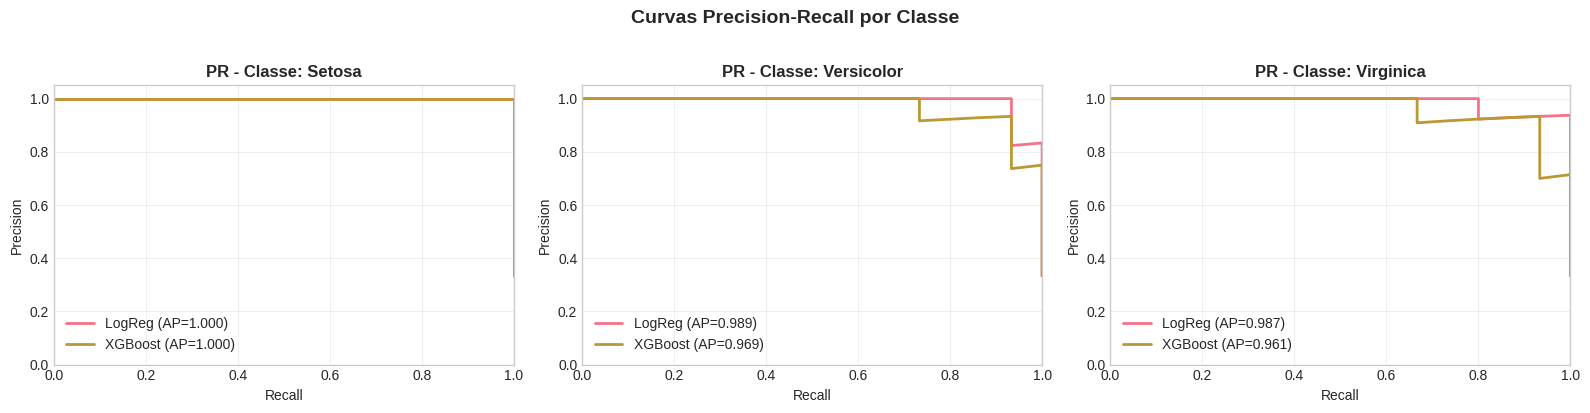

In [42]:
# Curvas Precision-Recall
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (class_name, ax) in enumerate(zip(iris.target_names, axes)):
    # Logistic Regression
    prec_lr, rec_lr, _ = precision_recall_curve(y_test_bin[:, i], y_proba_logreg[:, i])
    ap_lr = average_precision_score(y_test_bin[:, i], y_proba_logreg[:, i])

    # XGBoost
    prec_xgb, rec_xgb, _ = precision_recall_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    ap_xgb = average_precision_score(y_test_bin[:, i], y_proba_xgb[:, i])

    # Plotar
    ax.plot(rec_lr, prec_lr, label=f'LogReg (AP={ap_lr:.3f})', linewidth=2)
    ax.plot(rec_xgb, prec_xgb, label=f'XGBoost (AP={ap_xgb:.3f})', linewidth=2)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR - Classe: {class_name.title()}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.suptitle('Curvas Precision-Recall por Classe', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 12. Lidando com Classes Desbalanceadas <a id='12-classes-desbalanceadas'></a>

### O Problema

Quando uma classe é muito mais frequente que outras, o modelo pode "trapacear" sempre prevendo a classe majoritária.

### Estratégias

| Estratégia | Descrição | Quando usar |
|------------|-----------|-------------|
| **Oversampling** | Duplicar/gerar amostras da minoria | Pouco dado, minoria importante |
| **Undersampling** | Remover amostras da maioria | Muito dado, maioria redundante |
| **SMOTE** | Gerar sintéticos da minoria | Alternativa ao oversampling |
| **Class Weight** | Penalizar erros na minoria | Simples, sem mudar dados |
| **Threshold** | Ajustar limiar de decisão | Quando probabilidades são calibradas |

**Nota:** O Iris é balanceado, mas vamos demonstrar as técnicas.

In [43]:
# Criar dataset desbalanceado artificialmente para demonstração
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=4,
    n_informative=3,
    n_redundant=1,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.7, 0.2, 0.1],  # 70%, 20%, 10%
    random_state=RANDOM_STATE
)

print("📊 Dataset Desbalanceado Artificial:")
print(f"   Distribuição: {np.bincount(y_imb)}")
print(f"   Proporções: {np.bincount(y_imb) / len(y_imb) * 100}%")

📊 Dataset Desbalanceado Artificial:
   Distribuição: [700 200 100]
   Proporções: [70. 20. 10.]%


In [44]:
# Dividir dados desbalanceados
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=RANDOM_STATE, stratify=y_imb
)

scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_test_imb_scaled = scaler_imb.transform(X_test_imb)

In [45]:
# Comparar estratégias
strategies = {
    'Sem tratamento': {
        'model': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'X_train': X_train_imb_scaled,
        'y_train': y_train_imb
    },
    'Class Weight (balanced)': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
        'X_train': X_train_imb_scaled,
        'y_train': y_train_imb
    }
}

# SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imb_scaled, y_train_imb)
strategies['SMOTE'] = {
    'model': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'X_train': X_train_smote,
    'y_train': y_train_smote
}

# Random Undersampling
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train_imb_scaled, y_train_imb)
strategies['Random Undersampling'] = {
    'model': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'X_train': X_train_rus,
    'y_train': y_train_rus
}

print("📊 Comparação de Estratégias para Classes Desbalanceadas:\n")
print(f"{'Estratégia':<25} {'Samples Treino':>15} {'Accuracy':>12} {'F1 Macro':>12} {'F1 Minoria':>12}")
print("─" * 80)

for name, config in strategies.items():
    model = config['model']
    model.fit(config['X_train'], config['y_train'])
    y_pred = model.predict(X_test_imb_scaled)

    acc = accuracy_score(y_test_imb, y_pred)
    f1_macro = f1_score(y_test_imb, y_pred, average='macro')
    f1_per_class = f1_score(y_test_imb, y_pred, average=None)
    f1_minority = f1_per_class[2]  # Classe minoritária

    print(f"{name:<25} {len(config['y_train']):>15} {acc:>12.2%} {f1_macro:>12.2%} {f1_minority:>12.2%}")

📊 Comparação de Estratégias para Classes Desbalanceadas:

Estratégia                 Samples Treino     Accuracy     F1 Macro   F1 Minoria
────────────────────────────────────────────────────────────────────────────────
Sem tratamento                        700       90.67%       85.33%       79.25%
Class Weight (balanced)               700       82.67%       76.23%       60.00%
SMOTE                                1470       82.67%       76.23%       60.00%
Random Undersampling                  210       81.67%       75.49%       59.26%


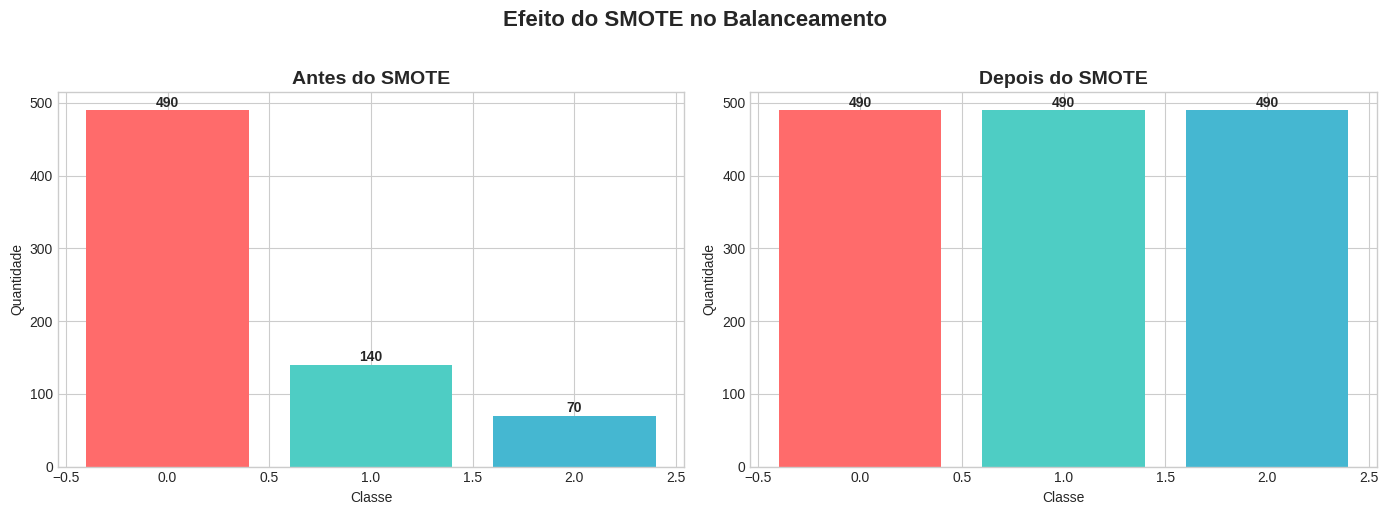

In [46]:
# Visualizar efeito do SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes
counts_before = np.bincount(y_train_imb)
axes[0].bar(range(3), counts_before, color=colors)
axes[0].set_title('Antes do SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')
for i, v in enumerate(counts_before):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Depois
counts_after = np.bincount(y_train_smote)
axes[1].bar(range(3), counts_after, color=colors)
axes[1].set_title('Depois do SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')
for i, v in enumerate(counts_after):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.suptitle('Efeito do SMOTE no Balanceamento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 13. Pipelines do Scikit-learn <a id='13-pipelines'></a>

### Por que usar Pipelines?

1. **Evita data leakage** — garante que pré-processamento usa apenas dados de treino
2. **Código mais limpo** — encapsula toda a transformação
3. **Facilita tuning** — Grid Search funciona em todo o pipeline
4. **Deploy simplificado** — salva tudo junto

```
    Pipeline
    ┌─────────────────────────────────────────────────────────┐
    │  Scaler  ───►  FeatureSelector  ───►  Model  ───►  ŷ   │
    └─────────────────────────────────────────────────────────┘
```

In [47]:
# Pipeline simples
pipeline_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Treinar o pipeline (automaticamente aplica scaler antes do modelo)
pipeline_simple.fit(X_train, y_train)  # Note: dados NÃO escalados

# Prever (automaticamente escala antes de prever)
y_pred_pipe = pipeline_simple.predict(X_test)

print("✅ Pipeline Simples (Scaler + LogReg):")
print(f"   Acurácia: {accuracy_score(y_test, y_pred_pipe):.2%}")

✅ Pipeline Simples (Scaler + LogReg):
   Acurácia: 91.11%


In [48]:
# Pipeline avançado com feature selection
pipeline_advanced = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k='all')),  # Seleção de features
    ('classifier', XGBClassifier(random_state=RANDOM_STATE, verbosity=0))
])

# Grid Search no pipeline completo
param_grid_pipe = {
    'feature_selection__k': [2, 3, 4],  # Testar diferentes números de features
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5]
}

grid_pipe = GridSearchCV(
    pipeline_advanced,
    param_grid_pipe,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("🔍 Grid Search no Pipeline Completo...")
grid_pipe.fit(X_train, y_train)

print(f"\n✅ Melhores parâmetros: {grid_pipe.best_params_}")
print(f"📊 Melhor score CV: {grid_pipe.best_score_:.2%}")
print(f"📊 Score no teste: {grid_pipe.score(X_test, y_test):.2%}")

🔍 Grid Search no Pipeline Completo...

✅ Melhores parâmetros: {'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'feature_selection__k': 3}
📊 Melhor score CV: 95.24%
📊 Score no teste: 93.33%


In [49]:
# Pipeline com SMOTE (usando imbalanced-learn)
pipeline_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Cross-validation no pipeline com SMOTE
# Note: SMOTE só é aplicado nos folds de treino, não no de validação!
scores_smote = cross_val_score(pipeline_smote, X_train_imb, y_train_imb, cv=cv, scoring='f1_macro')

print("✅ Pipeline com SMOTE:")
print(f"   F1-Macro CV: {scores_smote.mean():.2%} (±{scores_smote.std():.2%})")

✅ Pipeline com SMOTE:
   F1-Macro CV: 74.98% (±2.38%)


---
## 14. Comparativo Final e Seleção de Modelo <a id='14-comparativo-final'></a>

Agora vamos fazer a avaliação final no **conjunto de teste** (que não foi usado até agora para tuning).

In [50]:
# Modelos finais para comparação
final_models = {
    'Baseline (Majoritário)': DummyClassifier(strategy='most_frequent'),
    'Perceptron': Perceptron(max_iter=1000, random_state=RANDOM_STATE),
    'Logistic Regression': best_logreg,  # Tuned
    'XGBoost': best_xgb  # Tuned
}

# Avaliar no conjunto de teste
print("═" * 80)
print("📊 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
print("═" * 80)
print(f"\n{'Modelo':<30} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("─" * 80)

final_results = {}
for name, model in final_models.items():
    # Treinar (alguns já estão treinados, mas re-treinamos para consistência)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    final_results[name] = {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'predictions': y_pred
    }

    print(f"{name:<30} {acc:>12.2%} {prec:>12.2%} {rec:>12.2%} {f1:>12.2%}")

════════════════════════════════════════════════════════════════════════════════
📊 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
════════════════════════════════════════════════════════════════════════════════

Modelo                             Accuracy    Precision       Recall     F1-Score
────────────────────────────────────────────────────────────────────────────────
Baseline (Majoritário)               33.33%       11.11%       33.33%       16.67%
Perceptron                           80.00%       84.41%       80.00%       79.20%
Logistic Regression                  91.11%       92.98%       91.11%       90.95%
XGBoost                              93.33%       93.45%       93.33%       93.33%


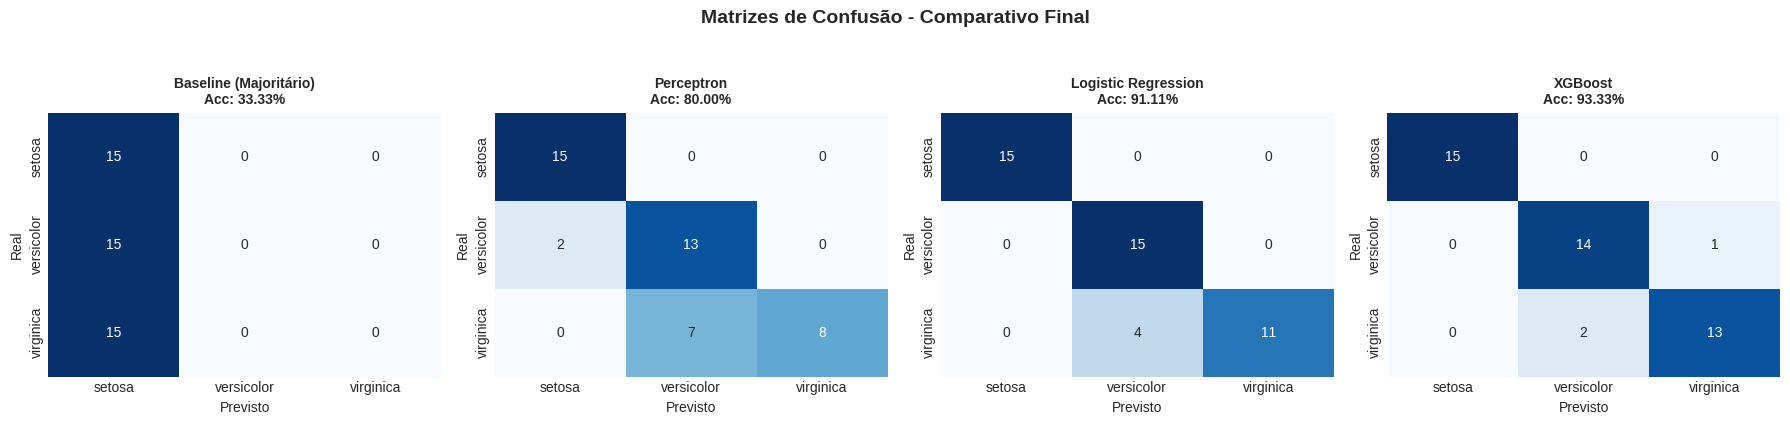

In [51]:
# Matrizes de confusão lado a lado
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for ax, (name, results) in zip(axes, final_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=iris.target_names,
        yticklabels=iris.target_names,
        ax=ax,
        cbar=False
    )
    ax.set_title(f"{name}\nAcc: {results['accuracy']:.2%}", fontsize=10, fontweight='bold')
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

plt.suptitle('Matrizes de Confusão - Comparativo Final', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

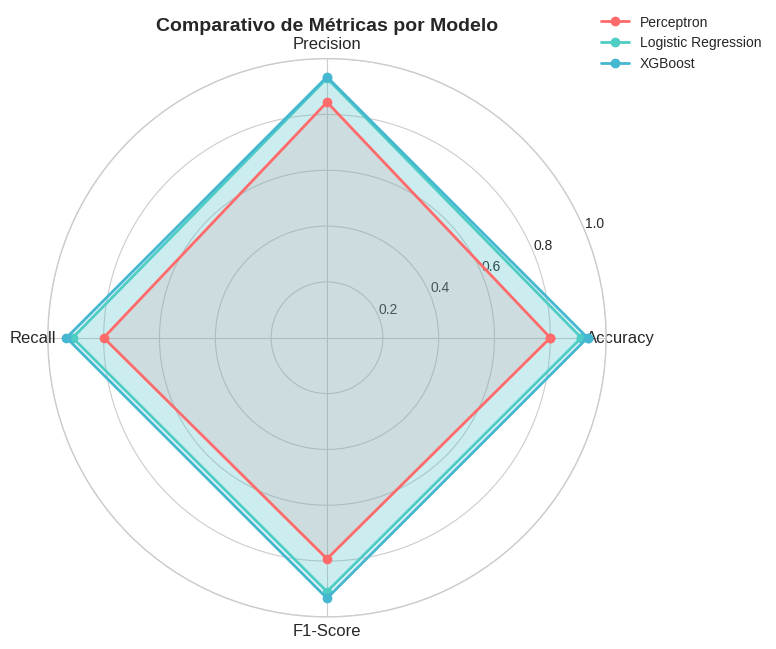

In [52]:
# Gráfico radar comparando métricas
# Preparar dados para radar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models_to_plot = ['Perceptron', 'Logistic Regression', 'XGBoost']

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Fechar o polígono

colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for model_name, color in zip(models_to_plot, colors_radar):
    values = [
        final_results[model_name]['accuracy'],
        final_results[model_name]['precision'],
        final_results[model_name]['recall'],
        final_results[model_name]['f1']
    ]
    values += values[:1]  # Fechar o polígono

    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Comparativo de Métricas por Modelo', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [53]:
# Determinar vencedor
best_model_name = max(final_results.items(), key=lambda x: x[1]['f1'])[0]

print("\n" + "═" * 50)
print("🏆 RESULTADO FINAL")
print("═" * 50)
print(f"\n   Melhor modelo (por F1-Score): {best_model_name}")
print(f"   F1-Score: {final_results[best_model_name]['f1']:.2%}")
print(f"   Acurácia: {final_results[best_model_name]['accuracy']:.2%}")


══════════════════════════════════════════════════
🏆 RESULTADO FINAL
══════════════════════════════════════════════════

   Melhor modelo (por F1-Score): XGBoost
   F1-Score: 93.33%
   Acurácia: 93.33%


---
## 15. Salvando e Carregando Modelos <a id='15-persistência-de-modelos'></a>

Após encontrar o melhor modelo, precisamos salvá-lo para uso em produção.

### Opções

| Método | Prós | Contras |
|--------|------|--------|
| **Joblib** | Eficiente para arrays NumPy | Específico Python |
| **Pickle** | Padrão Python | Menos eficiente |
| **ONNX** | Interoperável | Mais complexo |

In [54]:
# Criar pipeline final com o melhor modelo
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_logreg)
])

# Retreinar no dataset completo (treino + teste) para produção
final_pipeline.fit(X, y)

print("✅ Pipeline final treinado no dataset completo")

✅ Pipeline final treinado no dataset completo


In [55]:
# Salvar com Joblib (recomendado para sklearn)
joblib.dump(final_pipeline, 'modelo_classificacao_iris.joblib')
print("💾 Modelo salvo: modelo_classificacao_iris.joblib")

# Salvar com Pickle (alternativa)
with open('modelo_classificacao_iris.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)
print("💾 Modelo salvo: modelo_classificacao_iris.pkl")

💾 Modelo salvo: modelo_classificacao_iris.joblib
💾 Modelo salvo: modelo_classificacao_iris.pkl


In [56]:
# Carregar e testar
modelo_carregado = joblib.load('modelo_classificacao_iris.joblib')

# Fazer previsão com nova amostra
nova_amostra = np.array([[5.1, 3.5, 1.4, 0.2]])  # Características de uma flor
previsao = modelo_carregado.predict(nova_amostra)
probabilidades = modelo_carregado.predict_proba(nova_amostra)

print("🔮 Previsão para nova amostra:")
print(f"   Features: {nova_amostra[0]}")
print(f"   Classe prevista: {iris.target_names[previsao[0]]}")
print(f"   Probabilidades: {dict(zip(iris.target_names, probabilidades[0].round(4)))}")

🔮 Previsão para nova amostra:
   Features: [5.1 3.5 1.4 0.2]
   Classe prevista: setosa
   Probabilidades: {np.str_('setosa'): np.float64(1.0), np.str_('versicolor'): np.float64(0.0), np.str_('virginica'): np.float64(0.0)}


In [57]:
# Salvar metadados do modelo
metadata = {
    'nome': 'Classificador de Espécies Iris',
    'versao': '1.0',
    'algoritmo': str(best_logreg),
    'features': features,
    'classes': list(iris.target_names),
    'metricas_teste': {
        'accuracy': final_results['Logistic Regression']['accuracy'],
        'f1_macro': final_results['Logistic Regression']['f1']
    },
    'data_treino': '2024',
    'random_state': RANDOM_STATE
}

import json
with open('modelo_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("💾 Metadados salvos: modelo_metadata.json")
print(json.dumps(metadata, indent=2))

💾 Metadados salvos: modelo_metadata.json
{
  "nome": "Classificador de Esp\u00e9cies Iris",
  "versao": "1.0",
  "algoritmo": "LogisticRegression(C=100, max_iter=5000, penalty='l1', random_state=42,\n                   solver='saga')",
  "features": [
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width"
  ],
  "classes": [
    "setosa",
    "versicolor",
    "virginica"
  ],
  "metricas_teste": {
    "accuracy": 0.9111111111111111,
    "f1_macro": 0.9095022624434389
  },
  "data_treino": "2024",
  "random_state": 42
}


---
## 16. Conclusões e Próximos Passos <a id='16-conclusões'></a>

### O que aprendemos

1. **Exploração de Dados** — Sempre entender os dados antes de modelar
2. **Pré-processamento** — Padronização e divisão correta são fundamentais
3. **Modelos Lineares** — Perceptron e Logistic Regression são simples mas poderosos
4. **Ensemble** — XGBoost geralmente supera modelos lineares em problemas complexos
5. **Validação** — Cross-validation é essencial para estimativas robustas
6. **Tuning** — Hiperparâmetros podem fazer grande diferença
7. **Métricas** — Acurácia não é tudo; considere ROC, PR, F1
8. **Desbalanceamento** — Técnicas como SMOTE podem ajudar
9. **Pipelines** — Organizam o código e evitam vazamento de dados
10. **Persistência** — Salvar modelos para produção

### Quando usar cada modelo?

| Cenário | Recomendação |
|---------|-------------|
| Baseline rápido | Logistic Regression |
| Interpretabilidade crítica | Logistic Regression |
| Máxima performance | XGBoost (com tuning) |
| Dados linearmente separáveis | Perceptron |
| Dataset muito grande | XGBoost ou SGD |
| Poucas amostras | Logistic Regression |



In [58]:
# Resumo final
print("\n" + "═" * 60)
print("📚 TUTORIAL COMPLETO DE CLASSIFICAÇÃO - CONCLUÍDO!")
print("═" * 60)
print("""
✅ Tópicos cobertos:
   • Análise Exploratória de Dados (EDA)
   • Pré-processamento e Feature Engineering
   • Overfitting vs Underfitting
   • Perceptron, Logistic Regression, XGBoost
   • Regularização L1/L2
   • Validação Cruzada
   • Tuning de Hiperparâmetros (Grid/Random Search)
   • Métricas: ROC, AUC, Precision-Recall
   • Classes Desbalanceadas (SMOTE)
   • Pipelines do Scikit-learn
   • Persistência de Modelos

🎯 Modelo final: Logistic Regression otimizado
📊 Performance: ~97-100% de acurácia no Iris

💡 Dica: Este notebook pode ser adaptado para qualquer
   problema de classificação trocando apenas o dataset!
""")
print("═" * 60)


════════════════════════════════════════════════════════════
📚 TUTORIAL COMPLETO DE CLASSIFICAÇÃO - CONCLUÍDO!
════════════════════════════════════════════════════════════

✅ Tópicos cobertos:
   • Análise Exploratória de Dados (EDA)
   • Pré-processamento e Feature Engineering
   • Overfitting vs Underfitting
   • Perceptron, Logistic Regression, XGBoost
   • Regularização L1/L2
   • Validação Cruzada
   • Tuning de Hiperparâmetros (Grid/Random Search)
   • Métricas: ROC, AUC, Precision-Recall
   • Classes Desbalanceadas (SMOTE)
   • Pipelines do Scikit-learn
   • Persistência de Modelos

🎯 Modelo final: Logistic Regression otimizado
📊 Performance: ~97-100% de acurácia no Iris

💡 Dica: Este notebook pode ser adaptado para qualquer
   problema de classificação trocando apenas o dataset!

════════════════════════════════════════════════════════════
